# Classifying Amusement Park Reviews

Greg Trunz, Jr.

<b>Overview:</b> This notebook trains three types of machine learning classifiers &mdash; Multinomial Naive Bayes (MNB), Logistic Regression (LR), and Support Vector Machine (SVM) &mdash; to determine whether customer reviews of the Disneyland amusement park in California are positive or negative. These classification methods were selected because they tend to perform well at classifying bodies of text, and they produce interpretable models that allow for feature analysis. Analyzing the features enables us to identify specific words and phrases that tend to be associated with either positive or negative reviews, and can be useful for uncovering key areas of customer satisfaction and dissatisfaction.

For each of the three classifier types, we examine various text pre-processing specifications in combination with different model hyperparameters via stratified five-fold cross-validation on a training dataset. The pre-processing specifications and hyperparameters that achieve the best mean cross-validation accuracy scores are selected, resulting in three classifiers &mdash; one each for MNB, LR, and SVM. For these three classifiers, we then apply a more robust repeated cross-validation method to the training data and perform hypothesis tests on the results to determine whether any of the three classifiers performs statistically significantly better than the others. Lastly, these same three classifiers are trained on the full training set and used to make predictions on a hold-out testing dataset. For the testing set, other indicators of performance in addition to accuracy scores &mdash; including sensitivity, specificity, and area under the receiver operating characteristic (ROC) curve (AUC) scores &mdash; are examined. Although accuracy scores are intuitive and straightforward, they do not provide a full picture of model performance, and these additional metrics help give additional nuance. The three models are re-trained on the combined set of training and testing data prior to conducting feature analysis.

All three classifier types performed reasonably well, with mean cross-validation accuracy scores around 85-86 percent on data with a balanced 50-50 class distribution. Although SVM outperformed MNB and LR classifiers in terms of mean cross-validation accuracy, the hypothesis test did not establish that any of the three classifiers performed statistically significantly better than the others, and the LR classifier achieved a slightly higher score on the testing set than the others, with about 85.9 percent accuracy. The classifiers generated informative feature scores, identifying not only words that have positive or negative connotation in general &mdash; such as "amazing" and "disappointing," respectively &mdash; but also words that reveal more specific points of approval &mdash; e.g., "fun," "clean," and "all ages" &mdash; and disapproval &mdash; e.g., "overpriced," "long lines," and "broke down." 

The dataset used in this analysis was posted to Kaggle by Arush Chillar and can be found on Kaggle under a CC0 Public Domain license: https://www.kaggle.com/datasets/arushchillar/disneyland-reviews. (Last accessed on 20 November 2023).

First, we import relevant libraries.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy.stats
from collections import Counter, OrderedDict
import joblib
from IPython.display import Markdown, Latex

import re
import string
from nltk import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

We will also suppress warnings to keep the notebook clean. This is not recommended if you are running the code for the first time, as it could suppress important warnings specific to the environment in which the code is run. To avoid suppressing warnings, set `suppress_warnings` to `False` or simply refrain from running the below cell.

In [2]:
#specify whether to suppress warnings...note: doing so will also suppress parallelization and increase run time 
suppress_warnings = True
if suppress_warnings:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn
    
#specify whether to export models
export_models = True

The next cell reads in the data, subsets it to include only the California location and the relvant columns &mdash; `Review_Text` and `Rating`, which it renames as `text` and `rating`, respectively. It also provides a preview of the data, showing the first few rows, and the dimensions of the data. We can see that the data contains 19,406 reviews.

In [3]:
#read-in data
data = pd.read_csv('data.csv', encoding='latin-1')

#filter to include only the california branch
data = data[data['Branch'].str.contains('California')].reset_index(drop = True)

#keep only the text of the reviews and the ratings
data = data[['Review_Text','Rating']].rename(columns = {'Review_Text':'text','Rating':'rating'})

#show the first few rows
display(data.head())

#show the dimensions of the data
print(f'Shape: {data.shape[0]} rows, {data.shape[1]} columns.')

,text,rating
0,This place has always been and forever will be...,5
1,A great day of simple fun and thrills. Bring c...,5
2,All and all a great day was had. The crowds ar...,4
3,Having been to the Florida location numerous t...,5
4,"Had the 4 day pass, spent 3 at DL and one at C...",5


Shape: 19406 rows, 2 columns.


## Exploratory Data Analysis (EDA) and Pre-Processing

### Class Distributions

Now we can do some basic exploratory analysis. First, we take a look at the distribution of ratings. The plot below shows that the reviews are overwhelmingly positive, with more than 60 percent of reviews giving the highest rating of five. Fewer than three precent of reviews give the lowest rating of one.

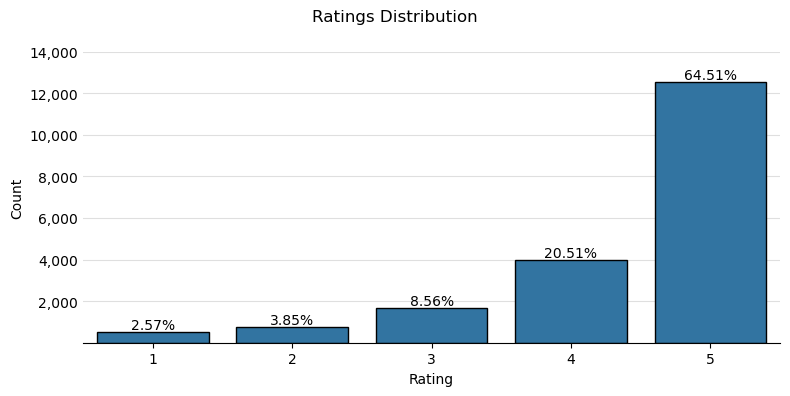

In [4]:
#plot distribution of ratings
plot_df = data.groupby('rating', as_index = False).size()
plot_df['rating_pct'] = (100*plot_df['size']/plot_df['size'].sum()).round(2).astype(str) + '%'
fig, ax = plt.subplots(1,1,figsize = (8,4))
sns.barplot(x = 'rating', y = 'size', data = plot_df, color = 'C0', edgecolor = 'black', ax = ax)
for i,row in plot_df.iterrows():
    ax.text(x = row['rating'] - 1, y = row['size'], s = row['rating_pct'], ha = 'center', va = 'bottom')
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.set_axisbelow(True)
ax.grid(axis = 'y', alpha = 0.4)
ax.tick_params(axis = 'y', length = 0)
rmv_spines = ['top','right','left']
for s in rmv_spines:
    ax.spines[s].set_visible(False)
ax.set_yticks(ax.get_yticks(),['{:,.0f}'.format(i) if i!=0 else ' ' for i in ax.get_yticks()])
fig.suptitle('Ratings Distribution')
fig.tight_layout()

For purposes of this analysis we will consider reviews with a rating of four or five to be "positive," while those with a rating less than four will be considered "negative." The cell below implements this logic, creating a `positive` variable, which takes a value of 1 for reviews with a rating of four or five, and 0 for reviews with a rating of three or below.

In [5]:
#define positive reviews as having >= 4 rating for all data -- both training and testing
data['positive'] = (data['rating']>=4).astype(int)

This `positive` variable will serve as the target variable that the machine learning models will try to predict based on the text of the reviews. We can see below that the target variable is quite imbalanced, with about 85 percent of the reviews belonging to the positive class.

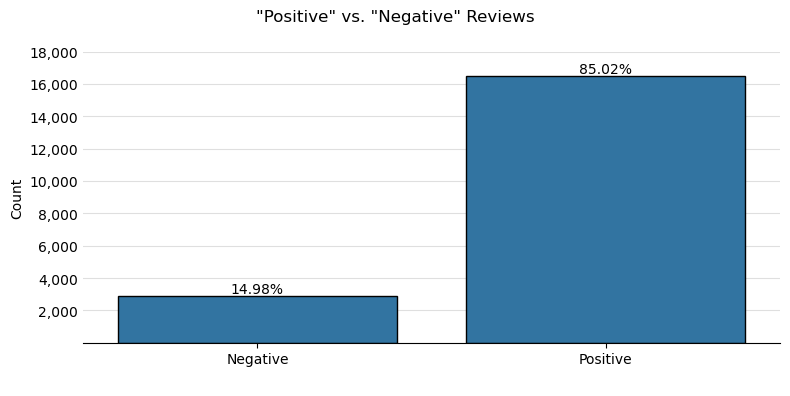

In [6]:
#plot positive vs. negative reviews
plot_df = data.groupby('positive', as_index = False).size()
plot_df['rating_pct'] = (100*plot_df['size']/plot_df['size'].sum()).round(2).astype(str) + '%'
fig, ax = plt.subplots(1,1,figsize = (8,4))
sns.barplot(x = 'positive', y = 'size', data = plot_df, color = 'C0', edgecolor = 'black', ax = ax)
for i,row in plot_df.iterrows():
    ax.text(x = row['positive'], y = row['size'], s = row['rating_pct'], ha = 'center', va = 'bottom')
ax.set_ylabel('Count')
ax.set_xlabel(' ')
ax.set_axisbelow(True)
ax.grid(axis = 'y', alpha = 0.4)
ax.tick_params(axis = 'y', length = 0)
rmv_spines = ['top','right','left']
for s in rmv_spines:
    ax.spines[s].set_visible(False)
ax.set_yticks(ax.get_yticks(),['{:,.0f}'.format(i) if i!=0 else ' ' for i in ax.get_yticks()])
ax.set_xticks(ax.get_xticks(),['Positive' if i!=0 else 'Negative' for i in ax.get_xticks()])
fig.suptitle(""""Positive" vs. "Negative" Reviews""")
fig.tight_layout()

Next, we subsample the data to achieve a balance between positive and negative classes. This approach may not always be advisable depending on the application, but is done here for the sake of simplicity. This will reduce the computation time for our models and make evaluating the models more straightforward. The cell below draws a random subsample of positive reviews that is equal in size to the number of negative reviews in the data, which happens to be 2,907.

In [7]:
#take sample of pos to reduce data and balance classes
pos_filt = data['positive']==1
data_pos = data[pos_filt]
data_neg = data[~pos_filt]
data_pos = data_pos.sample(n = data_neg.shape[0], random_state = 123)
data = pd.concat((data_pos,data_neg))
print(f'Positive Class Size: {data_pos.shape[0]}')
print(f'Negative Class Size: {data_neg.shape[0]}')
print(f'Total Samples: {data.shape[0]}')

Positive Class Size: 2907
Negative Class Size: 2907
Total Samples: 5814


The plot below shows the balance between the two classes after this subsampling.

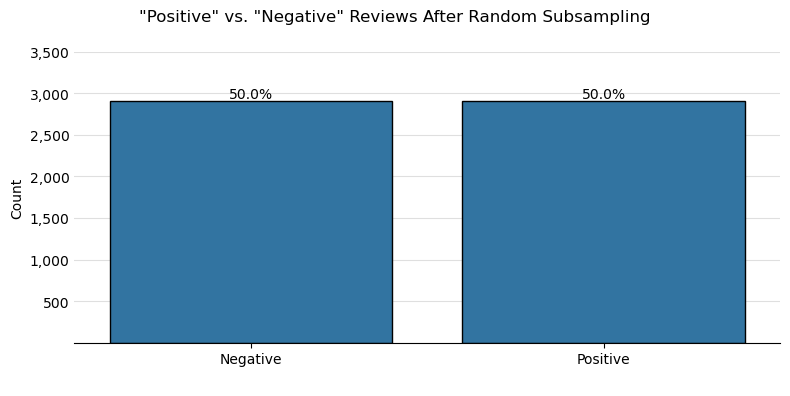

In [8]:
#plot positive vs. negative reviews
plot_df = data.groupby('positive', as_index = False).size()
plot_df['rating_pct'] = (100*plot_df['size']/plot_df['size'].sum()).round(2).astype(str) + '%'
fig, ax = plt.subplots(1,1,figsize = (8,4))
sns.barplot(x = 'positive', y = 'size', data = plot_df, color = 'C0', edgecolor = 'black', ax = ax)
for i,row in plot_df.iterrows():
    ax.text(x = row['positive'], y = row['size'], s = row['rating_pct'], ha = 'center', va = 'bottom')
ax.set_ylabel('Count')
ax.set_xlabel(' ')
ax.set_axisbelow(True)
ax.grid(axis = 'y', alpha = 0.4)
ax.tick_params(axis = 'y', length = 0)
rmv_spines = ['top','right','left']
for s in rmv_spines:
    ax.spines[s].set_visible(False)
ax.set_yticks(ax.get_yticks(),['{:,.0f}'.format(i) if i!=0 else ' ' for i in ax.get_yticks()])
ax.set_xticks(ax.get_xticks(),['Positive' if i!=0 else 'Negative' for i in ax.get_xticks()])
fig.suptitle(""""Positive" vs. "Negative" Reviews After Random Subsampling""")
fig.tight_layout()

### Word Frequency Analysis

The next cell implements a brief high-level word frequency analysis, showing the top words for each of the positive and negative classes, along with their frequency scores, in the two bar plots. The Venn diagram on the right compares the sets of most frequent words among the two classes. Words exclusive to the negative set include "long," "line," "people," and "crowded," while words exclusive to the positive set include "fun", "love," and "great," among others. There is considerable overlap between the word sets, and the intersection includes words common to both review sets, like "disney," "disneyland," "park," "food," "rides," and "lines." Since the top words from each set are limited to 20 for the sake of the visualizations, stop words are not included.

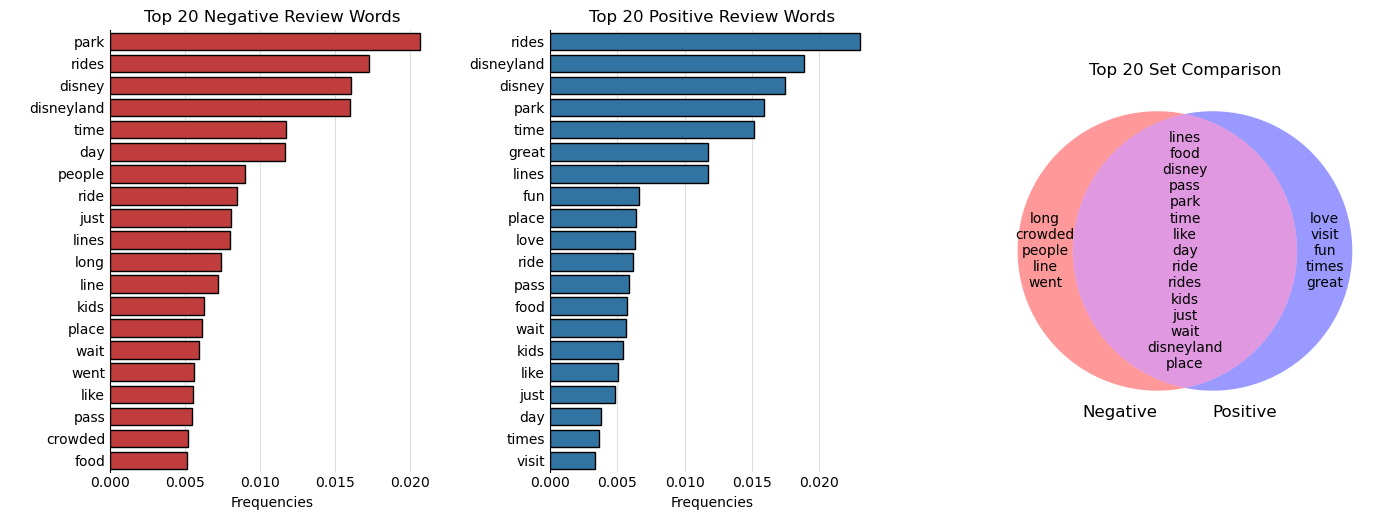

In [9]:
#compare top k words from positive and negtive reviews
top_k = 20

#count vectorization
vect = CountVectorizer(stop_words = 'english')
vect.fit(data['text'])
word_counts = np.asarray(vect.transform(data['text']).todense())
feature_names = vect.get_feature_names_out()

#split word_counts array into positive and negative review classes
pos = data['positive'].to_numpy()
pos_idx = pos == 1
neg_idx = pos == 0
pos_counts = word_counts[pos_idx,:]
neg_counts = word_counts[neg_idx,:]

#convert counts to frequencies by dividing counts by sum of each row (i.e., by total count for each review)
pos_freqs = pos_counts / pos_counts.sum(axis = 1).reshape((pos_counts.shape[0],1))
neg_freqs = neg_counts / neg_counts.sum(axis = 1).reshape((neg_counts.shape[0],1))

#get top 10 set of most frequent tokens for each class and their frequencies
pos_top_words = feature_names[np.argsort(-pos_freqs.mean(axis = 0))][:top_k]
pos_top_freqs = pos_freqs.mean(axis = 0)[np.argsort(-neg_freqs.mean(axis = 0))][:top_k]
neg_top_words = feature_names[np.argsort(-neg_freqs.mean(axis = 0))][:top_k]
neg_top_freqs = neg_freqs.mean(axis = 0)[np.argsort(-neg_freqs.mean(axis = 0))][:top_k]

#convert top tokens to sets
pos_set = set(pos_top_words)
neg_set = set(neg_top_words)

#apply logic for venn diagram plotting
pos_only = pos_set - neg_set
neg_only = neg_set - pos_set
both = pos_set.intersection(neg_set)

#make dfs for bar plots
pos_plot_df = pd.DataFrame({'Top Words':pos_top_words,'Frequencies':pos_top_freqs})\
                .sort_values('Frequencies', ascending = False)
neg_plot_df = pd.DataFrame({'Top Words':neg_top_words,'Frequencies':neg_top_freqs})\
                .sort_values('Frequencies', ascending = False)
#plot
fig, axes = plt.subplots(1,3, figsize = (14,5.3), width_ratios = [1,1,1.2])
#bar plots
bar_plot_dict = {'Negative Review':{'df':neg_plot_df,'color':'C3','ax':axes[0]},
             'Positive Review':{'df':pos_plot_df,'color':'C0','ax':axes[1]}}
for key,val in bar_plot_dict.items():
    sns.barplot(y = 'Top Words', x = 'Frequencies', data = val['df'], ax = val['ax'],
                color = val['color'], edgecolor = 'black')
    val['ax'].set_ylabel(' ')
    val['ax'].set_title(f'Top {top_k} {key} Words')
for ax in axes[:2]:
    ax.set_axisbelow(True)
    ax.grid(axis = 'x', alpha = 0.4)
    ax.tick_params(axis = 'both', length = 0)
    rmv_spines = ['top','right','bottom']
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
#venn diagram
venn_plot = venn2(subsets = [neg_set, pos_set], set_labels = ('Negative', 'Positive'), set_colors = ('red','blue'), 
                  ax = axes[2])
labels = {'100': neg_only, '010': pos_only, '110': both}
for subset, label in labels.items():
    venn_plot.get_label_by_id(subset).set_text('\n'.join(label))
axes[2].set_title(f'Top {top_k} Set Comparison')
fig.tight_layout()

### More Context with Word Associations

To get a bit more context on some of the topics common to both the positive and negative review classes, we can examine word association scores. Here we will look at the terms "lines," "food," and "rides," all of which were contained in the intersection of the above Venn diagram. The below bar plots show the top tri-grams associated with these words for each of the two classes. Similar to the above analysis, stop words are excluded. This helps reveal additional words that tend to appear (roughly) adjacent to the three words of interest, and can shed light on differences in how the these words are being used in the positive and negative classes. 

On the topic of "lines," the top tri-grams from the negative reviews typically indicate long wait times. Examples include "waiting long lines," "long lines everything," and "lines way long." The top tri-grams among positive reviews also often contain the term "long," but there are also some that carry a positive connotation, like "lines moved quicky" and "lines much shorter."

For "food," the top negative review tri-grams include the terms "expensive" and "prices." "Long lines" appears here as well. The top positive review tri-grams include "healthy food options," "food much better," and "food surprisingly good." Several of the tri-grams from both classes also seem to be related to bringing food to the park.

Finally, for "rides," the top tri-grams from the negative class appear focused on ride closures and, once again, long lines. "Many rides closed," "several rides closed," "wait times rides," and "long lines rides" are among the top tri-grams. The positive reviews' top tri-grams also mention "wait times," but not specific references to long lines or ride closures. We also see "popular rides" and "fast passes" each contained in more than one of the positive review tri-grams related to rides.

Overall, this shows that while the negative and positive reviews share some common topics, there are likely differences in how these topics are discussed between the two classes, which can be detected merely by looking at some of the words that appear near to these topics in the text. 

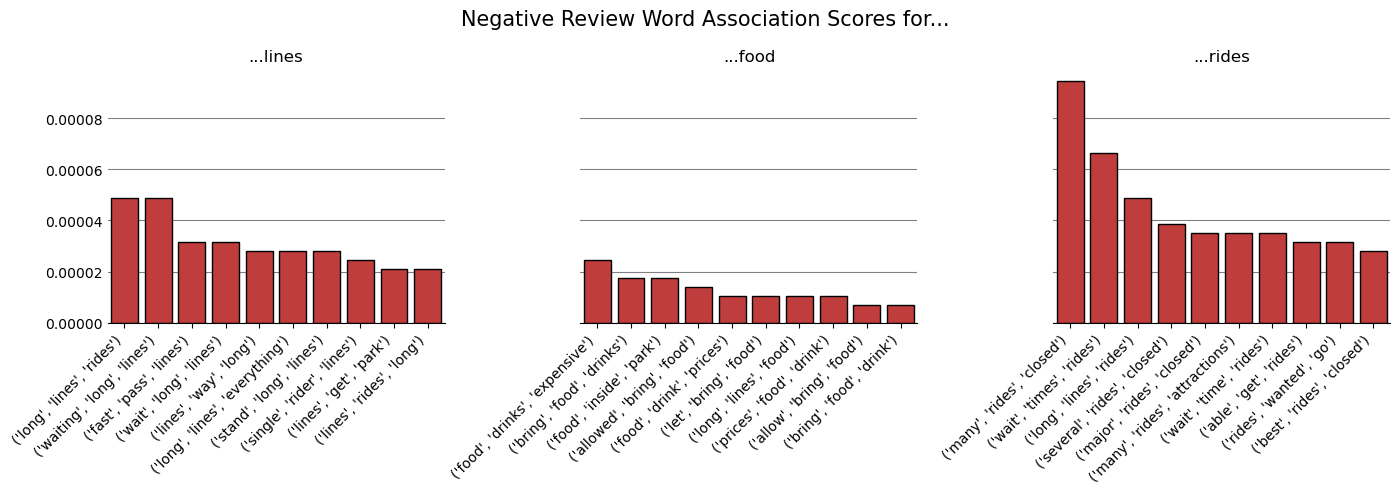

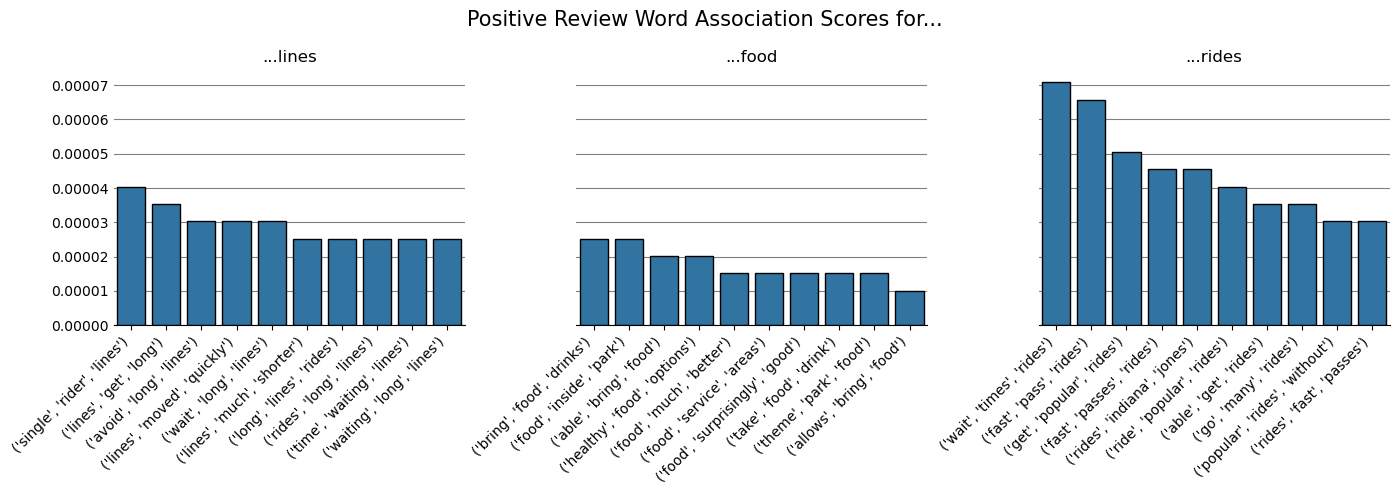

In [10]:
#function for plotting top k association scores for given word
def plot_word_assoc(word, assoc_scores, top_k, ax, color = 'C0'):
    custom_stop_words = {'and','the','from','of','are','as','a','is','but','which','to','at','in'}
    data_dict = OrderedDict({})
    pair_scores = [j for j in assoc_scores\
                   if (word in j[0]) and (np.all([k.isalpha() for k in j[0]]))\
                   and (np.all([k not in custom_stop_words for k in j[0]]))][:top_k]
    data_dict['pairs'] = [str(j[0]) for j in pair_scores]
    data_dict['assoc_scores'] = [j[1] for j in pair_scores] 
    xpos = list(range(len(data_dict['assoc_scores'])))
    ax.grid(color = 'gray', axis = 'y')
    ax.tick_params(axis = 'y', length = 0)
    ax.set_axisbelow(True)
    rmv_spines = ['top','right','left']
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
    sns.barplot(y = data_dict['assoc_scores'], x = xpos, ax = ax,
                color = color, edgecolor = 'black')
    ax.set_xticks(xpos,data_dict['pairs'], rotation = 45, ha = 'right')
    ax.set_title(f'...{word}')
    
#plot association scores for negative and positive classes
plot_words = ['lines','food','rides']
plot_dict = {'Negative Review':{'num':0,'color':'C3'},
             'Positive Review':{'num':1,'color':'C0'}}
for key,val in plot_dict.items():
    cls = val['num']
    color = val['color']
    title = key
    all_words = word_tokenize(' '.join(data['text'][data['positive'] == cls]).lower())
    all_words = [i for i in all_words if not i in stopwords.words('english')]
    collocation_finder = TrigramCollocationFinder.from_words(all_words)
    scores = collocation_finder.score_ngrams(TrigramAssocMeasures().raw_freq)
    fig, axes = plt.subplots(1,3, figsize = (14,5), sharey = True)
    for w,ax in zip(plot_words,axes):
        plot_word_assoc(word = w, assoc_scores = scores, top_k = 10, color = color, ax = ax)
        ax.ticklabel_format(style = 'plain', axis = 'y')
    fig.suptitle(f'{title} Word Association Scores for...', size = 15)
    fig.subplots_adjust(wspace = -.5)
    fig.tight_layout()

This analysis of word frequencies and associations gives us an initial indication that there are some intuitive and probably meaningful differences between the two classes of reviews, but this is just the tip of the iceberg in examining these differences. The machine learning classifiers should be able to dig deeper and uncover some of the key words and phrases most useful for distinguising between the positive and negative reviews.

## Machine Learning

The data that will be used for machine learning will not contain any punctuation, so punctuation is removed from each review in the below cell.

In [11]:
#remove punctuation from text
data['text'] = data['text'].apply(lambda x: ''.join([i for i in x if not i in string.punctuation]))

Next we split the data into sets of training and testing predictors $X$ and class labels $y$, with the training set containing 80 percent of the data and the testing set containing the remaining 20 percent. The data is shuffled prior to the split, and stratified based on the class labels to ensure the class labels are similarly balanced in both the training and testing sets. 

In [12]:
#train-test-split data
X_train, X_test, y_train, y_test = train_test_split(data[['text']],
                                                    data['positive'],
                                                    test_size = 0.2,
                                                    shuffle = True, 
                                                    stratify = data['positive'], 
                                                    random_state = 123)

### Specifying Text-Processing Pipeline Options:

Before machine learning models can be trained on text data, the text must be converted to a numerical represenation. There are many ways that this can be done. Here we designate a process consisting of (at most) two steps: (1) count vectorization and (2) term frequency-inverse document frequency (TF-IDF) transformation. For each of these steps, there are various specifications with many possible options, but for simplicity we will cross-validate just a handful of specifications with only a few options for each, as outlined below:

 - <b>1. Vectorization:</b> Vectorization is used to turn text strings &mdash; in our case, reviews &mdash; into numeric vector representations. (This was actually a technique used above for the word frequency analysis). Each position in the vector represents an n-gram consisting of at least a single word token, and the number at that position represents the frequency with which the n-gram appears in the text. Given our body of reviews, we can use this to convert the reviews into a numeric matrix of predictors $X \in \mathbb{R}^{n \times m}$, in which each row is a review, each column represents a unique n-gram, and the value at $X_{ij}$, $i \in \{1,...,n\}$, $j \in \{1,...,m\}$ is the number of times n-gram $j$ appears in review $i$. Scikit-Learn's `CountVectorizer` will be used to apply vectorization. It is defined using several parameters, and we will explore the following:<br><br>
     - `tokenizer`: The tokenizer specifies how string patterns within the original text are converted into individual token elements. The options we explore include: 
         - (1) `None`: Any unique substring that fits the default regex pattern `r'(?u)\b\w\w+\b'` becomes a token;<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)
         - (2) `stemming_tokenizer`: A custom tokenizer defined below, which uses the Natural Language Toolkit's (NLTK) Porter stemmer algorithm to stem any substring that fits the default regex pattern.<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3) This effectively converts certain words that have common roots and usually similar meanings into the same token. For example, whereas the first approach would treat "impressive," "impressed," "impression," and "unimpressive," as unique tokens, each with their own column in $X$, the second would yield just two tokens: "impress" and "unimpress." An advantage of this is that it reduces the dimensionality of the data, although a downside is that some potentially important nuance is lost. 
         
     - `max_df`: This is the maximum document frequency, and represents the maximum number or fraction of reviews in which a token can appear in the reviews for it to be included as a column in $X$. It can help exclude extremely common words from $X$. The options included here are: 
         - (1) 0.95, meaning a token can appear in at most 95 percent of reviews for it to be included.
         - (2) 0.85, meaning a token can appear in at most 85 percent of reviews for it to be included.
         - (3) 0.75, meaning a token can appear in at most 75 percent of reviews for it to be included.
     
     - `ngram_range`: The n-gram range allows $X$ to have predictors that represent more than a single word. Our options are:
         - (1) [1,1], meaning only single words will be used as predictors.
         - (2) [1,2], meaning both single words and phrases consisting of two adjacent words will be used as predictors. This second range will result in $X$ having many more predictors, but this could be worthwhile if there are two-word phrases that prove meaningful for prediction.<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3)
         
         
 - <b>2. TF-IDF Transformation</b>: While vectorization provides raw token counts within a review, TF-IDF imposes a penalty on tokens that are very common across all reviews. It therefore gives more weight to tokens that are very common to certain reviews but not common in general, potentially yielding more meaningful predictors. Here we use Scikit-Learn's implementation of the TF-IDF function for term $t$ in document $d$:<a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4)
 
 > Let:<br>- TF($t$,$d$) be the number of times term $t$ appears in document $d$<br> - DF($t$) be the number of documents in the corpus of all documents that contain the term $t$<br>- $n$ be the number of all documents in the corpus<br>- IDF($t$) $= \text{log}\left(\frac{1+n}{1+\text{DF}(t)}\right) + 1$ be the inverse document frequency penalty<br>Then:<br>$$\text{TF-IDF}(t,d)  = \text{TF}(t,d) \times \text{IDF(t)}$$
  
   TF-IDF specifications for which we will test different options include:
   - `norm`: This determines whether and how the features are normalized, and our options are: 
       - (1) L2, meaning  the TF-IDF scores are normalized such that the sum of all squared vector elements equals 1.
       - (2) `None`, meaning no normalization is implemented and raw values are used.
   - `use_idf`: This indicates whether to the IDF($t$) penalty term is included, and our options are:
       - (1) `True`, meaning IDF($t$) is included.
       - (2) `False`, meaning IDF($t$) penalty is not included (equivalently, IDF($t$) $=1$).<a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4)
       
 Note that if `norm` is set to None and `use_idf` is set to `False`, it is equivalent to skipping the TF-IDF transformation.

<a name="cite_note-1"></a><font size = "1.5">1. [^](#cite_ref-1) </font></a><font size = "1.5">Scikit-Learn 1.2.2. (2023). "sklearn.feature_extraction.text.CountVectorizer." https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html (Last accessed 05/14/2023).</font><br>
<a name="cite_note-2"></a><font size = "1.5">2. [^](#cite_ref-2) </font></a><font size = "1.5">NLTK. (2023). "Sample usage for stem." https://www.nltk.org/howto/stem.html (Last accessed 05/14/2023).</font><br>
<a name="cite_note-3"></a><font size = "1.5">3. [^](#cite_ref-3) </font></a><font size = "1.5">Porter, Martin F. (1997). “An algorithm for suffix stripping.” <i>Program</i> 40. pp. 211-218. https://doi.org/10.1108/eb046814</font><br>
<a name="cite_note-4"></a><font size = "1.5">4. [^](#cite_ref-4) </font></a><font size = "1.5">Scikit-Learn 1.2.2. (2023). "sklearn.feature_extraction.text.TfidfTransformer." https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html (Last accessed 05/14/2023).</font><br>

The next cell defines the `stemming_tokenizer` we will use, as mentioned above. It also provides an example of how the tokenizers results might different from the non-stemming, default approach.

In [13]:
#define tokenizer with stemming
default_token_pattern = r'(?u)\b\w\w+\b'
stemmer = PorterStemmer()
def stemming_tokenizer(x):
    return [stemmer.stem(i) for i in re.findall(default_token_pattern, x)]

#see example of the difference that the stem tokenizer makes
example_text = """impressive impressed unimpressive impression."""
print('Example input text:\n\t{}'.format(example_text))
vect = CountVectorizer()
vect.fit_transform([example_text])
print('Default tokenizer features:\n\t',list(vect.get_feature_names_out()))
stemmed_vect = CountVectorizer(tokenizer = stemming_tokenizer, token_pattern = None)
stemmed_vect.fit_transform([example_text])
print('Stem tokenizer features:\n\t',list(stemmed_vect.get_feature_names_out()))

Example input text:
	impressive impressed unimpressive impression.
Default tokenizer features:
	 ['impressed', 'impression', 'impressive', 'unimpressive']
Stem tokenizer features:
	 ['impress', 'unimpress']


The below cell stores all of the text processing options that will be explored here in the dictionary `data_prep_specs`.

In [14]:
#define text processing specifications
data_prep_specs = {'vectorizer__tokenizer':[stemming_tokenizer,None],
                   'vectorizer__max_df':[0.95,0.85,0.75],
                   'vectorizer__ngram_range':[(1,1),(1,2)],
                   'tfidf__norm':['l2',None],
                   'tfidf__use_idf':[True,False]}

### Models and Hyperparameter Options

In addition to the data processing options, we also need to explore different model-specific hyperparameters &mdash; i.e., parameters selected in advance of training the models, as opposed to being estimated from the data by the models themselves &mdash; via cross-validation to see which perform best. This section explains the basics of each type of classifier and the significance of their hyperparameters. 

#### Multinomial Naive Bayes (MNB):

MNB is a probabilistic method that assigns data to the class with the greatest posterior probability, based on Bayes' theorem, defined as: 

> $$P(A|B) = \frac{P(A)\times P(B|A)}{P(B)} \quad \text{or} \quad \text{Posterior} = \frac{\text{Prior} \times \text{Likelihood}}{\text{Marginal}}$$

In a classification context, if we assume that each $j \in \{1,...,m\}$ feature in a predictor matrix $X \in \mathbb{R}^{n \times m}$ is independent of the others given a class $y \in \{0,...,c\}$, this translates to the following framework:<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5)<br><br>
>$$ P(y|x_1,...,x_m) = \frac{P(y) \times \prod_{j=1}^m P(x_j|y)}{P(x_1,...,x_m)}$$<br><br>

Since the marginal $P(x_1,...,x_m)$ is constant, the posterior is proportional to the product of the prior and likelihood, and the model will generate a class prediction $\hat{y}$ that maximizes this product:<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5)<br>
> $$ \hat{y} = \underset{y}{\operatorname{arg max}} P(y)\times \prod_{j=1}^m P(x_j|y)$$

For Scikit-Learn's implementation of the multinomial variant of naive Bayes, each class' prior probability parameter $P(y)$ is estimated as $\hat{p}(y) = \frac{n_y}{n}$, where $n$ is the total number of training samples and $n_y$ is the number of training samples belonging to class $y$. Each conditional probability for each feature $j$ and each class $y$, $P(x_j|y)$, is estimated with the following formula:<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5)

> $$\hat{p}(x_j|y) = \frac{\alpha+\sum_{x_i \in S_y} x_{ij}}{\alpha m+ \sum_{j=1}^m \sum_{x_i \in S_y} x_{ij}}$$

Here, each $x_{ij}$ is the value of predictor $j \in \{1,...,m \}$ for sample $i \in \{1,...,n \}$ from the training predictor matrix $X \in \mathbb{R}^{n \times m}$, $S_y$ is the set of training samples belonging to class $y$, and $\alpha \geq 0$ is a smoothing hyperparameter.

We will tune $\alpha$ via cross-validation. A key function of $\alpha$ is to avoid zero probabilities, but the specific value chosen can have important implications for the model. Larger values will tend to risk underfitting, whereas smaller values tend to risk overfitting.

Once the $P(y)$'s and $P(x_j|y)$'s are estimated using the training data, values proportional to the class probabilities can be generated for new samples with unknown class labels:<a name="cite_ref-6"></a>[<sup>[6]</sup>](#cite_note-6)

> $$ \hat{p}(y|x_{new}) \propto  \hat{p}(y) \times \prod_{j=1}^{m} \hat{p}(x_j|y)^{x_{new,j}}$$

We can introduce a denominator to normalize these values so that they sum to one over all classes and represent actual probability estimates:<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5)

> $$ \hat{p}(y|x_{new}) = \frac{ \hat{p}(y) \times \prod_{j=1}^{m} \hat{p}(x_j|y)^{x_{new,j}} } { \sum_{k=1}^{c} P(y_k|x_{new})}$$


<a name="cite_note-5"></a><font size = "1.5">5. [^](#cite_ref-5) </font></a><font size = "1.5">Scikit-Learn 1.2.2. (2023). User Guide. "Naive Bayes." https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes (Last accessed 05/09/2023).</font><br>
<a name="cite_note-6"></a><font size = "1.5">6. [^](#cite_ref-6) </font></a><font size = "1.5">Jiang, L., Wang, S., Li, C., & Zhang L. (2016). "Structure extended multinomial naive Bayes." <i>Information Sciences</i>, vol 329. https://doi.org/10.1016/j.ins.2015.09.037</font><br>


#### Logistic Regression (LR):

Logistic regression is another probability-oriented method. It aims to translate a sample of of predictors into a probability $p \in [0,1]$ based on the sigmoid function:<a name="cite_ref-7"></a>[<sup>[7]</sup>](#cite_note-7)

>$$ \hat{p} = \hat{p}(y = 1|x) = \text{sigmoid}(x^T\beta) = \frac{1}{1+e^{-(x^T\beta)}}$$

Here, $x \in \mathbb{R}^{m+1}$ represents a vector of $m$ predictors with a columns of 1 values appended to its left side, and $\beta \in \mathbb{R}^{m+1}$ is a vector consisting of an intercept term followed by coefficients corresponding to the predictors. The values of $\beta$ are those derived from minimizing the following function over the training data:<a name="cite_ref-7"></a>[<sup>[7]</sup>](#cite_note-7) 

>$$ \underset{\beta}{\operatorname{min}} r(\beta) + C \sum_{i=1}^{n} \left[ -y_i \text{log}(\hat{p}) -(1-y_i) \text{log}(1-\hat{p})  \right]$$

Coefficient value $\beta_j$ represents the estimated change in $\text{log}\left(\frac{p}{1-p}\right)$ &mdash; i.e., the estimated change in the log odds that $y=1$ &mdash; for each unit increase of the corresponding predictor variable $x_j$ when holding other predictors constant.<a name="cite_ref-8"></a>[<sup>[8]</sup>](#cite_note-8) The regularization term $r(\beta)$ limits the magnitude of coefficients and there are different options for the function $r$. We will use the default $r(\beta) = \frac{\beta^T\beta}{2}$.<a name="cite_ref-7"></a>[<sup>[7]</sup>](#cite_note-7)<a name="cite_ref-9"></a>[<sup>[9]</sup>](#cite_note-9)

$C$ is a hyperparameter that we will tune via cross-validation. It governs the strength of regularization.<a name="cite_ref-9"></a>[<sup>[9]</sup>](#cite_note-9)  Lower $C$ values give greater weight to the regularization term and yield smaller coefficients, while higher values give less weight to the regularization term and result in larger coefficients. Smaller $C$ values risk underfitting, whereas larger $C$ values risk overfitting.

With two classes, a new sample $x_{new}$ of an unknown class is predicted to belong to class 1 if $\hat{p}$ is greater than a given threshold (0.5 by default), and class 0 otherwise:

$$\begin{equation}
\hat{y} = 
\begin{cases}
  1, & \hat{p} > 0.5 \\
  0, & \text{otherwise}
\end{cases}
\end{equation}$$

 
<a name="cite_note-7"></a><font size = "1.5">7. [^](#cite_ref-7) </font></a><font size = "1.5">Scikit-Learn 1.2.2. (2023). User Guide. "Linear Models." https://scikit-learn.org/stable/modules/linear_model.html# (Last accessed 05/09/2023).</font><br>
<a name="cite_note-8"></a><font size = "1.5">8. [^](#cite_ref-8) </font></a><font size = "1.5">Pohlman, J.T., & Leitner, D.W. (2003). "A Comparison of Ordinary Least Squares and Logistic Regression." https://kb.osu.edu/bitstream/handle/1811/23983/V103N5_118.pdf (Last accessed 05/10/2023).</font><br>
<a name="cite_note-9"></a><font size = "1.5">9. [^](#cite_ref-9) </font></a><font size = "1.5">Scikit-Learn 1.2.2. (2023). "sklearn.linear_model.LogisticRegression." https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html (Last accessed 05/09/2023).</font>

#### Support Vector Machine (SVM):

SVM differs from the other two methods in that it is based on geometry rather than probability. It specifies a boundary between the classes, which is defined by parameters $w \in \mathbb{R}^m$ and $b \in \mathbb{R}$. These parameters are derived from the following optimization problem using training sample predictors $x_i \in \mathbb{R}^m$, $i \in \{1,...,n\}$ and corresponding class labels $y_i \in \{-1,1\}$:<a name="cite_ref-10"></a>[<sup>[10]</sup>](#cite_note-10)<a name="cite_ref-11"></a>[<sup>[11]</sup>](#cite_note-11)

>$$ \underset{w,b,\epsilon}{\operatorname{min}} \frac{w^Tw}{2} + C \sum_{i=1}^n \epsilon_i$$
>$$\text{ s.t.: } y_i(w^Tx_i+b) \geq 1 - \epsilon_i \text{ and $\epsilon_i \geq 0$} \text{, } \forall \text{ } i$$

This is the linear version of SVM because it yields a linear hyperplane decision boundary. It also falls into the "soft-margin" category of SVM classifiers because it seeks to balance two goals: (1) maximizing the margin between the boundary of the classes so as to reduce the possibility of misclassifying new data points (i.e., minimizing $\frac{w^Tw}{2}$); and (2) minimizing the degree to which this boundary misclassifies or comes close to misclassifying training data points (i.e., minimizing $C \sum_{i=1}^n \epsilon_i$). The $\epsilon_i$ terms represent the degree to which a training sample is misclassified or falls within the margin of the decision boundary, while the hyperparameter $C$ determines the weight that these penalties carry in the optimization problem.  <a name="cite_ref-10"></a>[<sup>[10]</sup>](#cite_note-10)<a name="cite_ref-11"></a>[<sup>[11]</sup>](#cite_note-11)<a name="cite_ref-12"></a>[<sup>[12]</sup>](#cite_note-12) 

We will tune $C$ via cross-validation. Larger $C$ values prioritize minimizing misclassifications or near-misclassifications of the training data, at the expense of maximizing the margins between the classes and the boundary, and can therefore result in overfitting, while smaller values prioritize larger margins but can cause underfitting.

Once the parameters $w$ and $b$ are specified, we have the decision boundary:<a name="cite_ref-11"></a>[<sup>[11]</sup>](#cite_note-11)

>$$ w^Tx+b = 0 $$

A new data point $x_{new}$ with an unknown class is assigned to the positive class if $w^Tx_{new}+b > 0 $ and to the negative class if $w^Tx_{new}+b < 0$:<a name="cite_ref-11"></a>[<sup>[11]</sup>](#cite_note-11)


$$\begin{equation}
\hat{y} = 
\begin{cases}
  +1, & w^Tx_{new}+b > 0\\
  -1, & w^Tx_{new}+b < 0
\end{cases}
\end{equation}$$


<a name="cite_note-10"></a><font size = "1.5">10. [^](#cite_ref-10) </font></a><font size = "1.5">Scikit-Learn 1.2.2. (2023). User Guide. "Support Vector Machines." https://scikit-learn.org/stable/modules/svm.html#svm-classification (Last accessed 05/09/2023).</font><br>
<a name="cite_note-11"></a><font size = "1.5">11. [^](#cite_ref-11) </font></a><font size = "1.5">Gavrilov, Z. (2012). "SVM Tutorial." Massachusetts Institute of Technology. https://web.mit.edu/zoya/www/SVM.pdf (Last accessed 05/09/2023).</font><br>
<a name="cite_note-12"></a><font size = "1.5">12. [^](#cite_ref-12) </font></a><font size = "1.5">Bishop, C.M. (2006). <i>Pattern Recognition and Machine Learning.</i> Springer.</font><br>

The below cell specifies all of the model hyperparameters that will be tested via cross-validation. For MNB's $\alpha$, we will test values 0.01, 0.1 and 1, and for both LR's $C$, and SVM's $C$, we will experiment with the values 1, 10 and 100. This is admittedly a small number of alternatives, so it is unlikely that any of them are optimal, but we are limiting the candidates because they will be examined in combination with all of the text processing specifications in cross-validation, which will take considerable time.

In [15]:
#MNB
MNB_model = MultinomialNB()
MNB_hyperparams = {'alpha':[0.01,0.1,1.0]}

#LR
LR_model = LogisticRegression(random_state = 123, max_iter = 5000)
LR_hyperparams = {'C':[1.0,10.0,100.0]}

#SVM
SVM_model = SVC(random_state = 123, max_iter = 5000, kernel = 'linear', probability = True)
SVM_hyperparams = {'C':[1.0,10.0,100.0]}

### Tuning Text Processing and Hyperparameter Specifications with Cross-Validation

In this section we will select the text processing specifications and model hyperparameters that achieve the best mean accuracy scores in stratified five-fold cross-validation for each of the three classifier types. The `Tuner` class defined below can be instantiated with a classification model, a dictionary of model-specific hyperparameters, and a cross-validation method as input. Its `tune` method runs cross-validation over all combinations of our text processing specifications and model hyperparameters. The `get_results` method can then return a dictionary containing: the classifier with the best performing text processing specifications and hyperparameter, trained on the full training dataset; this classifier's best mean cross-validation accuracy; this classifier's best text processing specifications and model hyperparameter; this classifier's best accuracy scores for each fold; and a dataframe containing the full cross-validation results. The `export_best` method can be used to export the classifier with the best performing text processing specification and hyperparameter, trained on the full dataset.

In [16]:
#defines Tuner class for tuning text processing specification and model hyperparameters
class Tuner:
    
    #constructor
    def __init__(self,model,model_hyperparams,cv_method,search_strategy = 'gs'):
        self.model = clone(model)
        self.model_hyperparams = model_hyperparams.copy()
        self.cv_method = cv_method
        self.search_strategy = search_strategy
        self.results = None
    
    #tune method
    def tune(self):        
        #specify preprocessing and modeling pipeline
        pipeline_steps = [('vectorizer',CountVectorizer()),
                          ('tfidf',TfidfTransformer()),
                          ('model',self.model)]
        pipeline = Pipeline(steps = pipeline_steps)
        #specify specs -- start with data_prep_specs
        params = data_prep_specs.copy()
        #add model-specific hyperparams
        for key,val in self.model_hyperparams.items():
            params['model__'+str(key)] = val
            
        #search based on search strategy
        #grid
        if self.search_strategy=='gs':
            #instantiate gridsearch
            if suppress_warnings:
                search = GridSearchCV(estimator = pipeline, param_grid = params, 
                                      cv = self.cv_method, scoring = 'accuracy', n_jobs = 1)
            else:
                search = GridSearchCV(estimator = pipeline, param_grid = params, 
                                      cv = self.cv_method, scoring = 'accuracy', n_jobs = -1)
        #halvingrandom
        elif self.search_strategy=='hrs':
            #instantiate halvingrandomsearch
            if suppress_warnings:
                search = HalvingRandomSearchCV(estimator = pipeline, param_distributions = params, 
                                               cv = self.cv_method, scoring = 'accuracy', random_state = 123, 
                                               n_jobs = 1)
            else:
                search = HalvingRandomSearchCV(estimator = pipeline, param_distributions = params, 
                                               cv = self.cv_method, scoring = 'accuracy', random_state = 123, 
                                               n_jobs = -1)
            
        #tune parameters and train model
        search.fit(X_train['text'],y_train)
        #store cv data in dataframe
        cv_df = pd.DataFrame(search.cv_results_)
        #get fold scores from cv_df
        best_fold_scores = cv_df[cv_df['rank_test_score']==1].iloc[0]\
                           [[i for i in cv_df.columns if re.match(r'split[0-9]',i)]].to_numpy().astype(float)
        #store and return results
        tune_results = {
                   'best_estimator':search.best_estimator_,
                   'best_cv_score':search.best_score_,
                   'best_specs':search.best_params_,
                   'best_fold_scores':best_fold_scores,
                   'cv_data':cv_df
                  }
        self.results = tune_results.copy()
        return self
            
    #get_results method
    def get_results(self):
        return self.results
    
    #export_best method
    def export_best(self, filename = 'model.joblib'):
        joblib.dump(self.results['best_estimator'], filename)
        print('Exported as:', filename)
        return None

Next we specify the cross-validation method as stratified five-fold cross-validation. Because it is stratified, each fold should have similar proportions of positive and negative reviews. We also specify that the search strategy over the various text processing specifications and model hyperparameters is grid search (`'gs'`), meaning that all combinations will be evaluated.

In [17]:
#specify cv method
cv_method = StratifiedKFold(n_splits = 5)
#specify search strategy
strategy = 'gs'

In the following three code cells, we apply the `Tuner` class to the three model types and print the results.

In [18]:
#MNB
#tune and get results
MNBtuner = Tuner(model = MNB_model, 
                 model_hyperparams = MNB_hyperparams, 
                 cv_method = cv_method, 
                 search_strategy = strategy)
MNB_cv_results = MNBtuner.tune().get_results()
#export best model if applicable
if export_models:
    MNBtuner.export_best(filename = 'mnb.joblib')
#store best cv fold scores
MNB_fold_scores = MNB_cv_results['best_fold_scores'] 
#print best mean cv score and best classifier specs
print('Best Mean CV Score:\n\t',round(MNB_cv_results['best_cv_score'],5))
MNB_bestspecs_string = '\n'.join(['\t{}: {}'.format(k,v)\
                                  for k,v in MNB_cv_results['best_specs'].items()])
print('Best Text Processing Specs and Model Hyperparams:\n',MNB_bestspecs_string)

Exported as: mnb.joblib
Best Mean CV Score:
	 0.85573
Best Text Processing Specs and Model Hyperparams:
 	model__alpha: 0.01
	tfidf__norm: l2
	tfidf__use_idf: False
	vectorizer__max_df: 0.95
	vectorizer__ngram_range: (1, 2)
	vectorizer__tokenizer: <function stemming_tokenizer at 0x7fc884414f70>


In [19]:
#LR
#tune and get results
LRtuner = Tuner(model = LR_model, 
                model_hyperparams = LR_hyperparams, 
                cv_method = cv_method, 
                search_strategy = strategy)
LR_cv_results = LRtuner.tune().get_results()
#export best model if applicable
if export_models:
    LRtuner.export_best(filename = 'lr.joblib')
#store best cv fold scores
LR_fold_scores = LR_cv_results['best_fold_scores'] 
#print best mean cv score and best classifier specs
print('Best Mean CV Score:\n\t',round(LR_cv_results['best_cv_score'],5))
LR_bestspecs_string = '\n'.join(['\t{}: {}'.format(k,v)\
                                 for k,v in LR_cv_results['best_specs'].items()])
print('Best Text Processing Specs and Model Hyperparams:\n',LR_bestspecs_string)

Exported as: lr.joblib
Best Mean CV Score:
	 0.8568
Best Text Processing Specs and Model Hyperparams:
 	model__C: 10.0
	tfidf__norm: l2
	tfidf__use_idf: True
	vectorizer__max_df: 0.85
	vectorizer__ngram_range: (1, 2)
	vectorizer__tokenizer: None


In [20]:
#SVM
#tune and get results
SVMtuner = Tuner(model = SVM_model, 
                 model_hyperparams = SVM_hyperparams, 
                 cv_method = cv_method, 
                 search_strategy = strategy)
SVM_cv_results = SVMtuner.tune().get_results()
#export best model if applicable
if export_models:
    SVMtuner.export_best(filename = 'svm.joblib')
#store best cv fold scores
SVM_fold_scores = SVM_cv_results['best_fold_scores'] 
#print best mean cv score and best classifier specs
print('Best Mean CV Score:\n\t',round(SVM_cv_results['best_cv_score'],5))
SVM_bestspecs_string = '\n'.join(['\t{}: {}'.format(k,v)\
                                  for k,v in SVM_cv_results['best_specs'].items()])
print('Best Text Processing Specs and Model Hyperparams:\n',SVM_bestspecs_string)

Exported as: svm.joblib
Best Mean CV Score:
	 0.85981
Best Text Processing Specs and Model Hyperparams:
 	model__C: 1.0
	tfidf__norm: l2
	tfidf__use_idf: True
	vectorizer__max_df: 0.85
	vectorizer__ngram_range: (1, 2)
	vectorizer__tokenizer: None


The results are summarized below in Table 1.
<br><br>

$$
\begin{aligned}
& \textbf{Table 1: Best Performing Text Processing Specifications and Hyperparameters}\\
&\begin{array}{rccccc}
\hline  \text{Model Type} & \text{Mean Accuracy} & \text{Hyperparameter} & \text{Stemming} & \text{N-Gram Range} &  \text{Max DF} & \text{TF-IDF}\\
\hline 
\text{MNB} & .8557 & \alpha = 0.01 & \text{Yes} & [1,2] & 0.95 & \text{norm = L2, use_idf = False}\\
\text{LR} & .8568 & C = 10 & \text{No} & [1,2] & 0.85 & \text{norm = L2, use_idf = True}\\
\text{SVM} & .8598 & C = 1 & \text{No} & [1,2] & 0.85 & \text{norm = L2, use_idf = True}\\
\hline
\end{array}
\end{aligned}
$$
<br>

These results indicate that the SVM classifier yielded the best accuracy on average, with a mean cross-validation score of about 0.8598, but MNB and LR were not far behind with 0.8557 and 0.8568, respectively. 

The mean cross-validation accuracy scores are just point estimates of model performance, however, and we can also look at the distributions of the accuracy scores across the folds to get more information about how the models performed. The below cell creates a function `plot_cv_folds` and uses it to show the cross-validation accuracy distributions with kernel density estimation for the three models, along with violin and swarm plots to portray the individual fold scores. The visualization shows considerable overlap in the distributions, which creates further doubt about whether SVM is significantly better than the other candidates. 

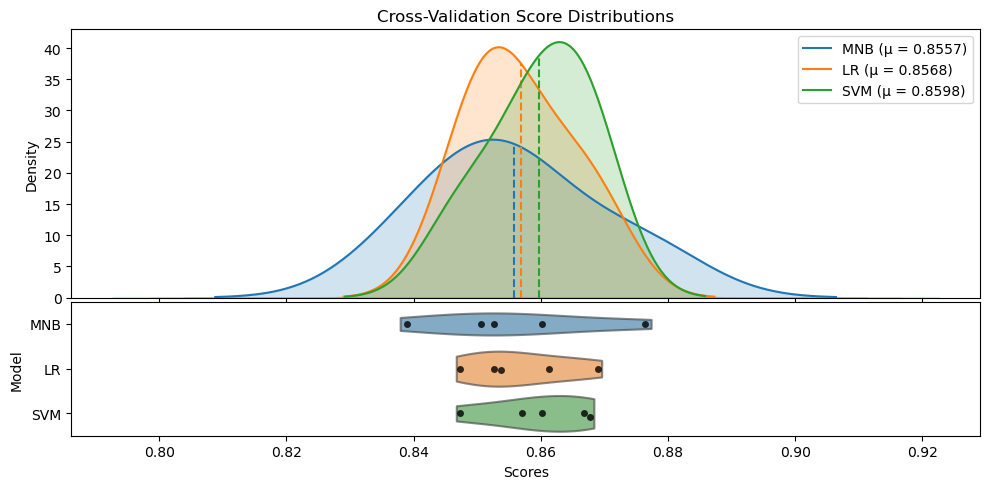

In [21]:
#defines function to help plotting cv score distributions
def plot_cv_folds(scores, labels, colors, title, kde_ax, violin_ax = False):
    #kde
    for s,l,c in zip(scores,labels,colors):
        mu = np.mean(s)
        sns.kdeplot(s, color = c, label = '{} (µ = {})'.format(l,round(mu,4)), ax = kde_ax)
        xmin, xmax = kde_ax.get_xlim()
        kernel = scipy.stats.gaussian_kde(s.astype(float))
        x_vals = np.linspace(xmin,xmax,1000)
        y_vals = kernel(x_vals)
        x_mean = x_vals[np.argmin(np.abs(x_vals - mu))]
        y_mean = y_vals[np.argmin(np.abs(x_vals - mu))]
        kde_ax.fill_between(x = x_vals, y1  = 0, y2 = y_vals, color = c, alpha = 0.2)
        kde_ax.vlines(x = x_mean, ymin = 0, ymax = y_mean, linestyle = '--', color = c)
    kde_ax.set_xlabel('')
    kde_ax.legend()
    kde_ax.set_title(title)
    #violin
    if violin_ax:
        name_vals  = [n for N in [[nm]*len(sc) for nm,sc in zip(labels,scores)] for n in N]
        score_vals = [s for S in scores for s in S]
        best_scores_df = pd.DataFrame({'Model':name_vals,'Scores':score_vals})
        sns.violinplot(x = 'Scores', y = 'Model', inner = None, cut = 0.1,
                       data = best_scores_df, ax = violin_ax)
        plt.setp(violin_ax.collections, alpha = 0.6)
        sns.swarmplot(x = 'Scores', y = 'Model', alpha = 0.8, color = 'black', 
                      data = best_scores_df, ax = violin_ax)
        violin_ax.set_xlabel('Scores')
        
#plot cv fold score distributions
scores = [MNB_fold_scores,LR_fold_scores,SVM_fold_scores]
labels = ['MNB','LR','SVM']
colors = ['C0','C1','C2']
title = 'Cross-Validation Score Distributions'
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (10,5), sharex = True, gridspec_kw = {'height_ratios': [2, 1]})
plot_cv_folds(scores, labels, colors, title = title, kde_ax = ax1, violin_ax = ax2)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.02)
plt.show()

Since each of the models are being trained and evaluated using the same sets of data for each fold, it also makes sense to compare each model's performance for each fold. The table generated in the below cell does this, and shows that MNB actually did best for three of the folds (including one two-way tie), despite having the lowest average. SVM did best for two of the folds (including one two-way tie), and LR did best for one of the folds.

In [22]:
#define get best function that gets the best scoring model from the rows of fold scores
def get_best(x):
    result = ''
    models = ['MNB','LR','SVM']
    mx_score = max([x[i] for i in models])
    for m in models:
        if x[m]==mx_score:
            if len(result)>0:
                result += ', {}'.format(m)
            else:
                result = m
    if ',' in result:
        result = 'Tie: '+result
    return result
#store scores in df
cv_score_df = pd.DataFrame({'MNB':MNB_fold_scores,
                            'LR':LR_fold_scores,
                            'SVM':SVM_fold_scores}, 
                           index = ['Fold {}'.format(i+1) for i in range(5)])
#apply best function to show best models
cv_score_df['Best'] = cv_score_df.apply(lambda x: get_best(x), axis = 1)
#display results
print('Fold Scores:')
display(cv_score_df)

Fold Scores:


,MNB,LR,SVM,Best
Fold 1,0.838883,0.868958,0.866810,LR
Fold 2,0.852688,0.852688,0.856989,SVM
Fold 3,0.850538,0.847312,0.847312,MNB
Fold 4,0.860215,0.853763,0.860215,"Tie: MNB, SVM"
Fold 5,0.876344,0.861290,0.867742,MNB


### Significance Testing with Repeated Cross-Validation

It is difficult to draw strong conclusions from the above, not only because the models' results are so similar, but because we are dealing with only five random partitions of the data &mdash; a very small sample size. A more rigorous approach that can be applied is hypothesis testing using repeated cross-validation, in which the folds are partitioned randomly with each repeat. We will implement this using stratified five-fold cross-validation, repeated eight times, yielding a total of 40 accuracy scores for each model. The hypothesis test we will use is the “corrected repeated k-fold cv test,” drawn from Bouckaert and Frank (2004) and outlined below:<a name="cite_ref-13"></a>[<sup>[13]</sup>](#cite_note-13)

Let:<br>- $k$ be the number of folds in a randomized k-fold cross-validation procedure<br>- $r$ be the number of times the randomized k-fold cross-validation procedure is repeated<br>- $d_{ij}$ be the difference between two machine learning model accuracy scores at fold $i \in {\{1,...,k\}}$ during run $j \in {\{1,...,r\}}$<br>- $\bar{D}$ be the sample mean of differences $d_{ij}$ across all $kr$ folds, and $D_{\mu}$ be the "true" mean difference in performance<br>- $n_{\text{test}}$ be the size of the testing set at each fold, and $n_{\text{train}}$ be the size of the training set at each fold.<br><br>Then we have our t-statistic:<br><br>

$$ T_0 = \frac{ \bar{D} }
{ \sqrt{\left(\frac{1}{kr} + \frac{n_{\text{test}}}{n_{\text{train}} }\right) \hat{\sigma}^2 }  } 
 \quad ,$$ <br>
$$\text{where:}\quad \bar{D} = \frac{1}{kr}\sum^{k}_{i=1}\sum^{r}_{j=1} d_{ij}, \quad \text{ and } \quad  \hat{\sigma}^2 = \frac{1}{kr-1}\sum^{k}_{i=1}\sum^{r}_{j=1}(d_{ij} - \bar{D})$$<br>
The correction lies in the $\left(\frac{1}{kr} + \frac{n_{\text{test}}}{n_{\text{train}} }\right)$ term, which is introduced to account for the fact that the sampling approach violates the paired t-test's independence assumption.

If model $A$'s mean accuracy scores outperform model $B$'s on average, we will perform a one-tailed (right-tailed) test with a significance level of $\alpha = 0.05$ and $kr-1$ degrees of freedom to test the null hypothesis that model $B$ is at least as accurate as model $A$, against the alternative that $A$ is more accurate than $B$, on average:

$$H_0: D_{\mu} \leq 0 \quad \text{ vs. } \quad H_A: D_{\mu} > 0,$$<br>

If this test results in a p-value less than $\alpha=0.05$, we will reject the null hypothesis and assume the alternative that $D_{\mu}>0$. In other words, we will assume that model $A$ is more accurate on average.

<a name="cite_note-13"></a><font size = "1.5">13. [^](#cite_ref-13) </font></a><font size = "1.5">Bouckaert, R.R., Frank, E. (2004). Evaluating the Replicability of Significance Tests for Comparing Learning Algorithms. In: Dai, H., Srikant, R., Zhang, C. (eds) Advances in Knowledge Discovery and Data Mining. PAKDD 2004. Lecture Notes in Computer Science, vol 3056. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-24775-3_3.</font>

The `CVRepeater` class defined below can be used to perform repeated cross-validation on a classifier using the `run_repeat_cv` method, which relies on Scikit-Learn's `RepeatedStratifiedKFold` class to partition the data into `n_splits`, repeated `n_repeats` times. The `get_scores` method returns the raw accuracies for all of the `n_splits` $\times$ `n_repeats` iterations. The `sig_test` method takes in accuracy scores from a different model that has undergone `run_repeat_cv` using the same number of `n_splits` and `n_repeats` as the model native to the `CVRepeater`, and implements the hypothesis test from Bouckaert and Frank (2004) comparing the two model accuracies as described above. It returns the differences in accuracy across all of the `n_splits` $\times$ `n_repeats` iterations and the p-value of the hypothesis test.

In [23]:
#defines CVRepeater class for implementing repeated cv with statistical test
class CVRepeater:

    #constructor
    def __init__(self,trained_model,random_state):
        self.model = clone(trained_model)
        self.random_state = random_state
        self.n_splits = None
        self.n_runs = None
        self.scores = None
        
    #run_repeat_cv method
    def run_repeat_cv(self,n_splits,n_repeats):
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        repeat_cv = RepeatedStratifiedKFold(n_splits = self.n_splits, 
                                            n_repeats = self.n_repeats, 
                                            random_state = self.random_state)
        scrs = []
        for train, test in repeat_cv.split(X_train, y_train):
            X_train_i,y_train_i = X_train.iloc[train],y_train.iloc[train]
            X_test_i, y_test_i  = X_train.iloc[test], y_train.iloc[test]
            model_i = clone(self.model)
            model_i.fit(X_train_i['text'], y_train_i)
            y_pred_i = model_i.predict(X_test_i['text'])
            scr = np.mean(y_test_i==y_pred_i)
            scrs.append(scr)
        self.scores = np.array(scrs)
        return self
    
    #get_scores method
    def get_scores(self):
        return self.scores
    
    #sig_test method based on "corrected repeated k-fold CV test" in Bouckaert and Frank (2004)
    def sig_test(self, other_scores, alpha = 0.05):
        #NOTE: Assumes `other_scores` generated using the same number of CV splits and repeats.
        a,b = self.scores.copy(),other_scores.copy()
        assert a.shape == b.shape, 'Error: The dimensions of the score arrays do not match.'
        k = self.n_splits
        D = a - b
        D_bar = np.mean(D)
        m = len(D) #m = kr
        deg_frdm = m - 1
        n = X_train.shape[0]
        n_test = round(n/k)
        n_train = n - n_test
        sig2 = np.sum( (D-D_bar)**2 ) / (deg_frdm)
        T = D_bar / np.sqrt( (1/m + (n_test/n_train)) * sig2  )
        critical_t = scipy.stats.t.ppf(q = 1 - alpha, df = deg_frdm)
        p = scipy.stats.t.sf(abs(T), df = deg_frdm)
        return D, p

The next cell applies the `CVRepeater` class to all three of the classifier types using stratified five-fold cross validation repeated eight times. It stores the accuracy scores across all of the 40 folds for each model, as well as the accuracy differences and p-values for each pair of models: MNB vs. LR, MNB vs. SVM, and SVM vs. LR.

In [24]:
#run repeated k-fold cross-validation for each of the three models
n_splits = 5
n_repeats = 8
MNB_cvr = CVRepeater(MNBtuner.get_results()['best_estimator'], random_state = 123)
MNB_cvr.run_repeat_cv(n_splits = n_splits, n_repeats = n_repeats)
MNB_cvr_scores = MNB_cvr.get_scores()

LR_cvr = CVRepeater(LRtuner.get_results()['best_estimator'], random_state = 123)
LR_cvr.run_repeat_cv(n_splits = n_splits, n_repeats = n_repeats)
LR_cvr_scores = LR_cvr.get_scores()

SVM_cvr = CVRepeater(SVMtuner.get_results()['best_estimator'], random_state = 123)
SVM_cvr.run_repeat_cv(n_splits = n_splits, n_repeats = n_repeats)
SVM_cvr_scores = SVM_cvr.get_scores()

#get the score differences and p-values of the corrected repeated k-fold cv tests
MNB_LR_diffs, MNB_LR_p = MNB_cvr.sig_test(LR_cvr_scores)
MNB_SVM_diffs, MNB_SVM_p = MNB_cvr.sig_test(SVM_cvr_scores)
SVM_LR_diffs, SVM_LR_p = SVM_cvr.sig_test(LR_cvr_scores)

Before examining the results, we can do a quick check of whether the accuracy differences between models are normally distributed &mdash; one of the key assumptions of a paired-samples t-test. The below cell performs a Shapiro-Wilk test, an appropriate normality test when the sample size is less than 50, with a significance level of $\alpha = 0.05$ for each sample of accuracy differences.<a name="cite_ref-14"></a>[<sup>[14]</sup>](#cite_note-14) The p-values of these tests are shown below. None of them are less than $0.05$, so in each case we fail to reject the null hypothesis that the differences are drawn from a normal distribution. 

<a name="cite_note-14"></a><font size = "1.5">14. [^](#cite_ref-14) </font></a><font size = "1.5">Ghasemi, A. & Zahediasl, S. (2012). "Normality Tests for Statistical Analysis: A Guide for Non-Statisticians." <i>International Journal of Endocrinology and Metabolism, 10</i> (2). pp. 486-489. https://doi.org/10.5812/ijem.3505.</font> 

In [25]:
#shapiro-wilk test for normality
diffs = [MNB_LR_diffs,MNB_SVM_diffs,SVM_LR_diffs]
names = ['MNB-LR Differences','MNB-SVM Differences','SVM-LR Differences']
for d,n in zip(diffs,names):
    print('{} Shapiro-Wilk p-value:\t'.format(n),round(scipy.stats.shapiro(d)[1],5))

MNB-LR Differences Shapiro-Wilk p-value:	 0.44004
MNB-SVM Differences Shapiro-Wilk p-value:	 0.44857
SVM-LR Differences Shapiro-Wilk p-value:	 0.45272


Next, the below visualization shows the results of the repeated cross-validation, as well as the hypothesis test results. Again, the three models achieved similar results and SVM had the best average score, although this time MNB had a slightly higher score than LR. None of the pairwise differences between the three models were statistically significant at the $\alpha = 0.05$ level. We therefore should refrain from making any hard conclusions that any of the models should be expected to perform better than the others, at least on this particular set of data.

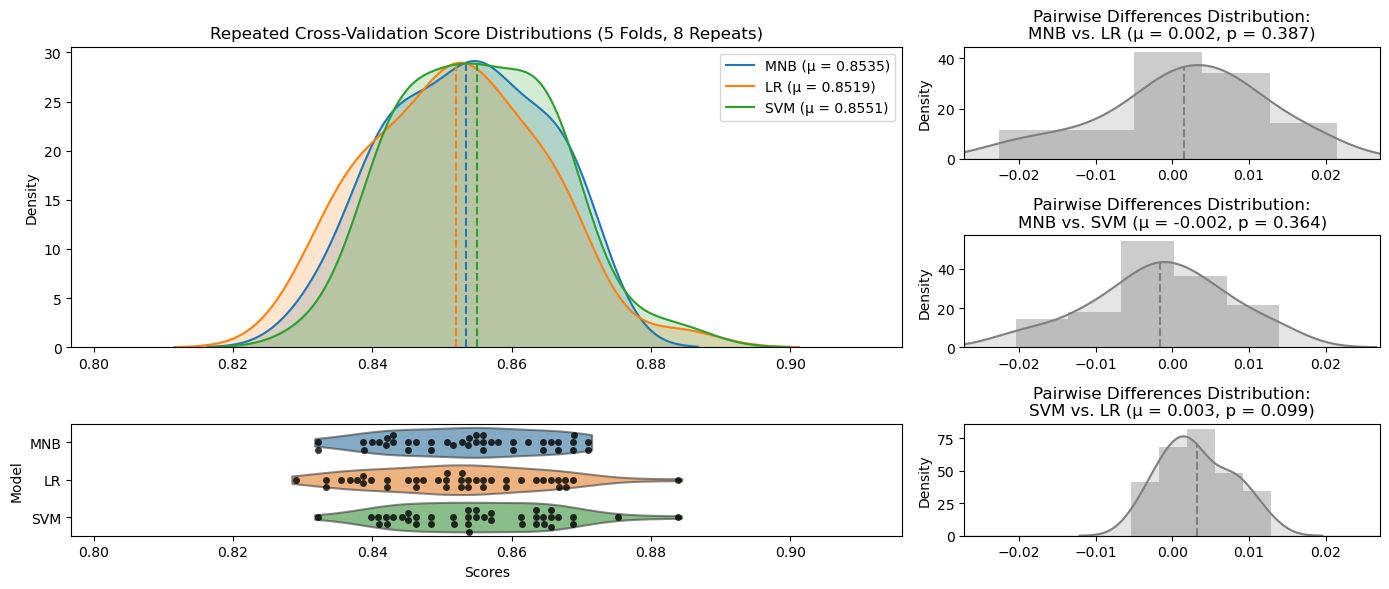

In [26]:
#set up figure
fig = plt.figure(figsize = (14,6), layout = 'tight')
gs = GridSpec(3,2, fig, width_ratios = [2,1])
ax1 = fig.add_subplot(gs[0:2,0])
ax2 = fig.add_subplot(gs[2,0], sharex = ax1)
ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1], sharex = ax3)
ax5 = fig.add_subplot(gs[2,1], sharex = ax3)

#plot folds
scores = [MNB_cvr_scores,LR_cvr_scores,SVM_cvr_scores]
labels = ['MNB','LR','SVM']
colors = ['C0','C1','C2']
title = 'Repeated Cross-Validation Score Distributions ({} Folds, {} Repeats)'\
            .format(n_splits, n_repeats)
plot_cv_folds(scores, labels, colors, title = title, kde_ax = ax1, violin_ax = ax2)

#plot diffs
pair_dict = {('MNB','LR'): {'diff':MNB_LR_diffs,  'ax': ax3, 'pval':MNB_LR_p},
             ('MNB','SVM'):{'diff':MNB_SVM_diffs, 'ax': ax4, 'pval':MNB_SVM_p},
             ('SVM','LR'): {'diff':SVM_LR_diffs,  'ax': ax5, 'pval':SVM_LR_p}}
mx_diff = np.max([MNB_LR_diffs,MNB_SVM_diffs,SVM_LR_diffs])
mn_diff = np.min([MNB_LR_diffs,MNB_SVM_diffs,SVM_LR_diffs])
for key,val in pair_dict.items():
    mu = np.mean(val['diff'])
    sns.distplot(val['diff'], bins = 5, color = 'gray', ax = val['ax'])
    val['ax'].set_xlim(-max([abs(mn_diff),abs(mx_diff)])*1.2,
                 max([abs(mn_diff),abs(mx_diff)])*1.2)
    val['ax'].set_title('Pairwise Differences Distribution:\n{} vs. {} (µ = {}, p = {})'\
                 .format( key[0], key[1], round(mu,3), round(val['pval'],3) ))
    xmin, xmax = val['ax'].get_xlim()
    kernel = scipy.stats.gaussian_kde(val['diff'])
    x_vals = np.linspace(xmin,xmax,1000)
    y_vals = kernel(x_vals)
    x_mean = x_vals[np.argmin(np.abs(x_vals - mu))]
    y_mean = y_vals[np.argmin(np.abs(x_vals - mu))]
    val['ax'].fill_between(x = x_vals, y1  = 0, y2 = y_vals, color = 'gray', alpha = 0.2)
    val['ax'].vlines(x = x_mean, ymin = 0, ymax = y_mean, linestyle = '--', color = 'gray')
plt.show()

### Model Testing

We will now see how these models perform in making predictions on the hold-out testing set of data. Overall accuracy will remain the primary metric by which we will evaluate the models, but other metrics will be introduced as well to enrich the analysis and examine how the models perform on each of the classes &mdash; both positive and negative reviews. These metrics include:

- <b>Sensitivity</b>: The proportion of positive reviews that the model classifies as being positive. Conceptually, this represents the model's ability to correctly classify positive reviews. This metric is also known as recall.
- <b>Specificity</b>: The proportion of negative reviews that the model classifies as being negative. This represents the model's ability to correctly classify negative reviews.
- <b>AUC Score</b>: AUC stands for area under the curve, specifically the receiver operator characteristic (ROC) curve. The ROC curve is a line representing a classifier's true positive rate (i.e., sensitivity) versus its false positive rate (i.e., 1-specificity) at different probability thresholds that could be used to convert a model's probability output for a sample to a class assignment.<a name="cite_ref-15"></a>[<sup>[15]</sup>](#cite_note-15) So the AUC score can be used to summarize a model's ability to maximize the true positive rate while minimizing the false positive rate across thresholds.<a name="cite_ref-16"></a>[<sup>[16]</sup>](#cite_note-16) Because both the true positive rate and false positive rate are both $\in [0,1]$, and AUC is measured along these two dimensions, the AUC score is also $\in [0,1]$. 


Confusion matrices and ROC curves are also used to visualize these metrics.

<a name="cite_note-15"></a><font size = "1.5">15. [^](#cite_ref-15) </font></a><font size = "1.5">Note that SVM does not directly use probabilities to make classification decisions. The probabilities used here are based on Platt scaling. The probabilities using this method may not align with the class labels that the model produces. See: Platt, J.C. (1999). “Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods.” https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf (Last accessed 05/16/2023); and Scikit-Learn 1.3.2. (2023). "Support Vector Machines." https://scikit-learn.org/stable/modules/svm.html#scores-probabilities (Last accessed 11/26/2023). </font><br>
<a name="cite_note-16"></a><font size = "1.5">16. [^](#cite_ref-16) </font></a><font size = "1.5">Mandrekar, J.M. (2010). 
"Receiver Operating Characteristic Curve in Diagnostic Test Assessment." <i>Journal of Thoracic Oncology, 5</i> (9), pp. 1315-1316. https://doi.org/10.1097/JTO.0b013e3181ec173d.</font> <br>

The below cell defines a `Tester` class, which is useful for much of the analysis in this section. It is instantiated with a trained model as input. Its `run_test` method uses the trained model to make predictions on the testing set and calculate the metrics listed above, which can be retrieved using the `get_test_metrics` method. The class can also be used to generate confusion matrices using the `plot_confusion` method, as well as ROC curves using the `plot_roc` method. 

In [27]:
#define Tester class
class Tester:
    
    #constructor
    def __init__(self,trained_model,ignore_probs = False):
        assert ignore_probs in {True,False} and type(ignore_probs)==bool, 'ignore_probs must be True or False.'
        self.model = trained_model
        self.ignore_probs = ignore_probs
        self.test_run = False
        self.y_pred = None
        if not self.ignore_probs:
            self.y_probs = None
        self.accuracy = None
        self.sensitivity = None
        self.specificity = None
        self.auc = None

    #test method
    def run_test(self):
        self.y_pred = self.model.predict(X_test['text'])
        self.accuracy = np.mean(self.y_pred==y_test)
        tp = confusion_matrix(y_test, self.y_pred)[1,1]
        p  = confusion_matrix(y_test, self.y_pred)[1].sum()
        tn = confusion_matrix(y_test, self.y_pred)[0,0]
        n  = confusion_matrix(y_test, self.y_pred)[0].sum()
        self.sensitivity = tp/p
        self.specificity = tn/n
        if not self.ignore_probs:
            self.y_probs = self.model.predict_proba(X_test['text'])
            self.auc = roc_auc_score(y_test, self.y_probs[:, 1])
        self.test_run = True
        return self
        
    #plot_confusion method
    def plot_confusion(self, model_type, ax = False):
        assert self.test_run, 'Error: Test has not been run.'
        if ax == False:
            ConfusionMatrixDisplay(confusion_matrix(y_test, self.y_pred)).plot()
            plt.title('Confusion Matrix')
            plt.show()
        else:
            ConfusionMatrixDisplay(confusion_matrix(y_test, self.y_pred)).plot(ax = ax)
            ax.set_title(model_type.upper()+\
              '\n(Sensitivity: {}, Specificity: {})'.format(round(self.sensitivity,3),round(self.specificity,3)))
            fig.suptitle('Confusion Matrices', size = 15)
            
    #plot_roc method
    def plot_roc(self, model_type, ax = False, plot_random_guess = False):
        assert self.ignore_probs != True, 'Error: ignore_probs is set to True.'
        assert self.test_run, 'Error: Test has not been run.'
        fp_rate, tp_rate, thresholds = roc_curve(y_test, self.y_probs[:,1])
        rand = np.array([0.5] * len(y_test))
        fp_rate_r, tp_rate_r, thresholds_r = roc_curve(y_test, rand)
        if ax == False:
            plt.plot(fp_rate, tp_rate, 
                     linewidth = 2,
                     label = '{} (AUC: {})'.format(model_type.upper(), round(self.auc,4)))
            if plot_random_guess == True:
                plt.plot(fp_rate_r, tp_rate_r, 
                         linestyle = '--', color = 'gray', label = 'Random Guess')
            plt.xticks(np.arange(0,11)/10)
            plt.yticks(np.arange(0,11)/10)
            plt.legend()
            plt.grid(alpha = 0.7)
            plt.title('Receiver Operating Characteristic Curve')
            plt.xlabel('False Positive Rate (1-Specificity)')
            plt.ylabel('True Positive Rate (Sensitivity)')
            plt.show()
        else:
            ax.plot(fp_rate, tp_rate, 
                    linewidth = 2,
                    label = '{} (AUC: {})'.format(model_type.upper(), round(self.auc,4)))
            if plot_random_guess == True:
                ax.plot(fp_rate_r, tp_rate_r, 
                        linestyle = '--', color = 'gray', label = 'Random Guess')
            ax.set_xticks(np.arange(0,11)/10)
            ax.set_yticks(np.arange(0,11)/10)
            ax.legend()
            ax.grid(alpha = 0.7)
            ax.set_title('Receiver Operating Characteristic Curve')
            ax.set_xlabel('False Positive Rate (1-Specificity)')
            ax.set_ylabel('True Positive Rate (Sensitivity)')
            
    #get_test_metrics method
    def get_test_metrics(self):
        assert self.test_run, 'Error: Test has not been run.'
        metrics =  {'accuracy': self.accuracy,  
                    'sensitivity': self.sensitivity, 
                    'specificity': self.specificity}
        if not self.ignore_probs:
            metrics = {'accuracy': self.accuracy,  
                       'sensitivity': self.sensitivity, 
                       'specificity': self.specificity,
                       'auc score':self.auc}
        return metrics
            
    
    #get_y_pred method
    def get_y_pred(self):
        assert self.test_run, 'Error: Test has not been run.'
        return self.y_pred
    
    #get_y_probs method
    def get_y_probs(self):
        assert self.ignore_probs!=True, 'Error: ignore_probs is set to True'
        return self.y_probs

The `Tester` class is applied to all three of the classifiers in the below three code cells. Test results are printed out from these cells, and also summarized in Table 2.

In [28]:
MNB_tester = Tester(MNB_cv_results['best_estimator'])
MNB_test_results = MNB_tester.run_test().get_test_metrics()
MNB_test_results_string = '\n'.join(['\t{}:\t {}'.format(k,round(v,5))\
                                     for k,v in MNB_test_results.items()])
print('MNB Test Scores:\n',MNB_test_results_string)

MNB Test Scores:
 	accuracy:	 0.85125
	sensitivity:	 0.81928
	specificity:	 0.88316
	auc score:	 0.93288


In [29]:
LR_tester = Tester(LR_cv_results['best_estimator'])
LR_test_results = LR_tester.run_test().get_test_metrics()
LR_test_results_string = '\n'.join(['\t{}:\t {}'.format(k,round(v,5))\
                                    for k,v in LR_test_results.items()])
print('LR Test Scores:\n',LR_test_results_string)

LR Test Scores:
 	accuracy:	 0.85899
	sensitivity:	 0.83821
	specificity:	 0.87973
	auc score:	 0.93551


In [30]:
SVM_tester = Tester(SVM_cv_results['best_estimator'])
SVM_test_results = SVM_tester.run_test().get_test_metrics()
SVM_test_results_string = '\n'.join(['\t{}:\t {}'.format(k,round(v,5))\
                                     for k,v in SVM_test_results.items()])
print('SVM Test Scores:\n',SVM_test_results_string)

SVM Test Scores:
 	accuracy:	 0.85727
	sensitivity:	 0.83305
	specificity:	 0.88144
	auc score:	 0.93307


$$
\begin{aligned}
& \textbf{Table 2: Model Performance on Hold-Out Testing Set}\\
&\begin{array}{rcccccc}
\hline  \text{Model Type} & \text{Accuracy} & \text{Sensitivity} & \text{Specificity} & \text{AUC Score} \\
\hline 
\text{MNB} & 0.8513 & 0.8193 & 0.8832^* & 0.9329\\
\text{LR} & 0.8590^* & 0.8382^* & 0.8797 & 0.9355^* \\
\text{SVM} & 0.8573 & 0.8331 & 0.8814 & 0.9331 \\
\hline
^*\text{Best score, or tied for best, for given metric.}
\end{array}
\end{aligned}
$$


Overall, the models' results on the testing set were not dramatically different from each other. The LR model achieved the best accuracy on the testing set with about 0.8590, followed by SVM with 0.8573 and MNB with 0.8513. LR also had the best sensitivity score but the worst specificity score, indicating it did the best at classifying the positive reviews, but the worst at classifying the negative reviews compared to the other models. Like all three of the models, LR's specificity score was higher than its sensitivity score, indicating that it was better at classifying the negative reviews than it was at classifying the positive reviews. LR also had the highest AUC score, meaning that it did the best at balancing true positives with false positives across the various probability thresholds.

The below cell shows the confusion matrices for each of the models. From these we can see the underlying figures used to derive the sensitivity and specificity scores. For example, for the MNB model, the sensitivity score is $0.819 \approx 476/(105+476)$ and the specificity score is $0.883 \approx 514/(514+68)$.

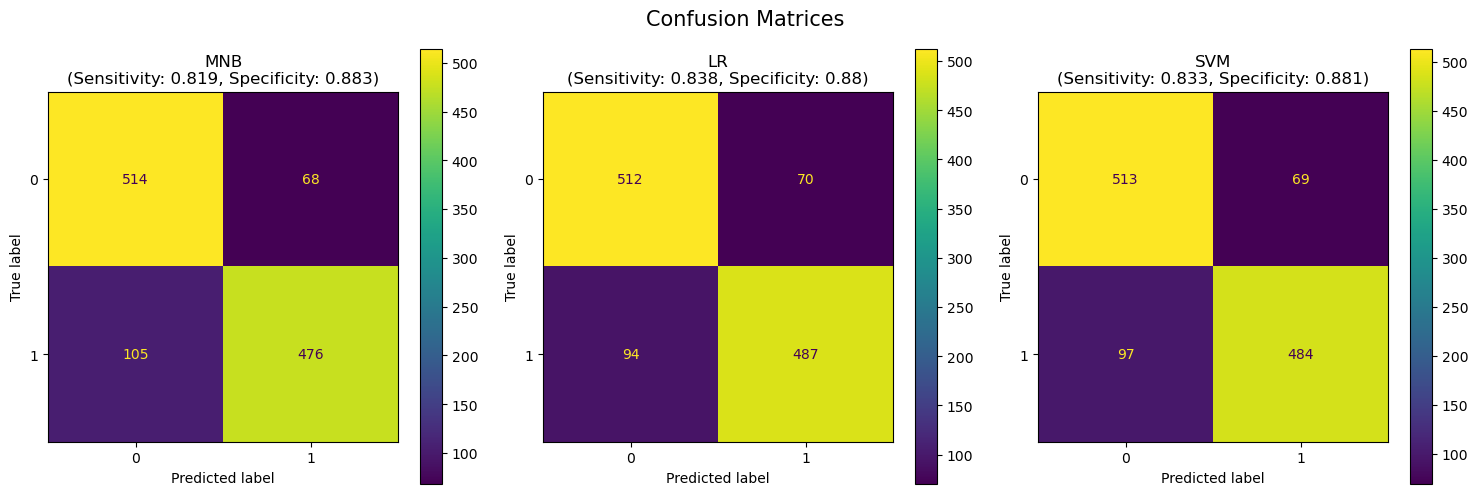

In [31]:
#plot confusion matricies
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize  = (15,5))
MNB_tester.plot_confusion(model_type = 'mnb', ax = ax1)
LR_tester.plot_confusion(model_type  = 'lr',  ax = ax2)
SVM_tester.plot_confusion(model_type = 'svm', ax = ax3)
fig.tight_layout()

Next we can look at the ROC curves that correspond to the models' AUC scores. 

The lower left quadrant of the below plot represents high classification thresholds, where classifiers will only classify a sample as being positive when it estimates that the probability of the sample belonging to the positive class is very high. Thus, in this region, the classifier is unlikely to classify any of the samples as positive and we expect to get very few false positives but also very few true positives. Moving towards the upper right quadrant, we reduce the threshold and we start to see more true positives but also more false positives. Visually, as the threshold is reduced, a strong classifier's ROC curve initially has a very steep upward slope, moving from the lower left corner of the plot toward the upper left corner of the plot, where true positive rates are highest and false positive rates are lowest. The better the classifier, the higher it will move along the Y axis before its slope curves and eventually flattens. This corresponds to a large AUC. In contrast, a poor classifier will start to have a significant number of false positives relative to the number of true positives as the threshold is reduced, resulting in a curve that remains far from the upper left corner of the plot and a small AUC.

Here we see that the models' curves are not very different from each other, which is not surprising given their similar AUC scores. The LR model has the highest AUC score overall, but we can see that it does not outperform the other models uniformly throughout the curve. It does tend to be further to the left for moderate to high thresholds, achieving lower false positive rates when the true positive rates are between around 0.45-0.9, although for true positive rates above 0.9, the MNB model tends to achieve lowest false positive rates.

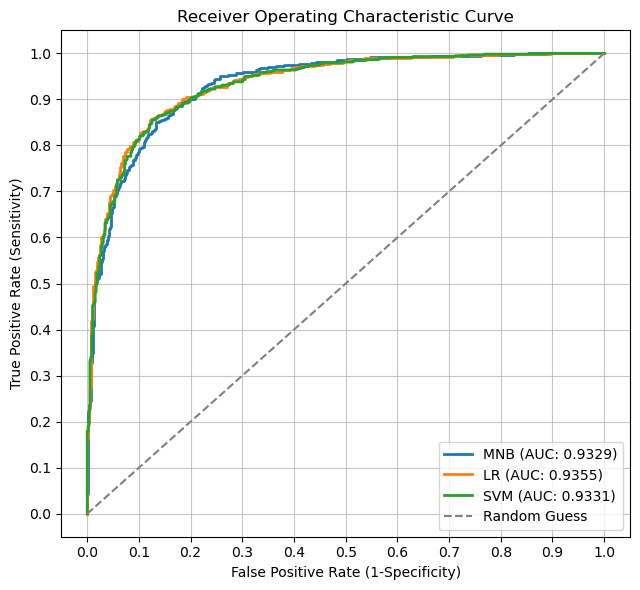

In [32]:
#roc
fig, ax = plt.subplots(1,1, figsize  = (6.5,6))
MNB_tester.plot_roc(model_type = 'mnb', ax = ax)
LR_tester.plot_roc(model_type = 'lr', ax = ax)
SVM_tester.plot_roc(model_type = 'svm', ax = ax, plot_random_guess = True)
fig.tight_layout()

### Feature Analysis

Lastly, we will identify some of the words that the models are utilizing to make predictions. This is one way to explore interesting terms associated with positive and negative classes, which can in turn reveal some key points of customer satisfaction and dissatisfaction.

The `FeatureAnalyzer` class defined in the below code cell is a tool designed to do this for the three models. It is instantiated with a trained classifier, and computes feature scores associated with both positive and negative classes based on the classifier type (MNB, LR, or SVM). It can also plot these scores using its `plot_feature_scores` method. 

These feature scores are computationally and conceptually distinct for each model type, so feature scores should only be compared for a given classifier, and not across different classifiers. The following is a brief explanation of how `FeatureAnalyzer` scores and ranks features for the positive and negative classes:

- <b>MNB Scores:</b> To get MNB's scores corresponding to the positive and negative classes, we start with the conditional log probabilities for each feature $j$ and each class $y$ (i.e., $\text{log}P\left(x_j|y\right)$), which can be pulled directly from the Scikit-Learn `MultinomialNB` classifier used here via its `feature_log_prob_` attribute. These raw values are arguably not the best way to identify features of interest for a given class, because very common tokens across both classes will have high conditional probabilities for both classes. However, one way to quantify their <i>relative</i> association with each class based on these raw values is to compute odds ratios, using the following steps for each feature $j$:
    1. Get feature $j$'s conditional log probabilities for positive and negative classes, $\text{log}P(x_j|y = \text{Positive})$ and $\text{log}P(x_j|y = \text{Negative})$, respectively.
    2. Convert these log probabilities to odds with respect to each class: 
    
    $$\text{Odds}_{j,\text{Positive}} = \frac{\text{exp}\left(\text{log}P(x_j|y = \text{Positive})\right)}{1-\text{exp}\left(\text{log}P(x_j|y = \text{Positive})\right)} = \frac{P(x_j|y = \text{Positive})}{1-P(x_j|y = \text{Positive})}$$ 
    $$\text{Odds}_{j,\text{Negative}} = \frac{\text{exp}\left(\text{log}P(x_j|y = \text{Negative})\right)}{1-\text{exp}\left(\text{log}P(x_j|y = \text{Negative})\right)} = \frac{P(x_j|y = \text{Negative})}{1-P(x_j|y = \text{Negative})}$$
    
    3. Finally, we will refer to $\frac{\text{Odds}_{j,\text{Positive}}}{\text{Odds}_{j,\text{Negative}}}$ as feature $j$'s odds ratio associated with the positive class, and $\frac{\text{Odds}_{j,\text{Negative}}}{\text{Odds}_{j,\text{Positive}}}$ as feature $j$'s odds ratio associated with the negative class. 
    
  Using these values, we can more easily identify features that tend to have high probabilities corresponding to the positive class <i>relative to</i> their conditional probabilities corresponding to the negative class, and vice versa. The top-ranked positive features are those with the highest $\frac{\text{Odds}_{\text{Positive}}}{\text{Odds}_{\text{Negative}}}$ values, and the top-ranked negative features are those with the highest $\frac{\text{Odds}_{\text{Negative}}}{\text{Odds}_{\text{Positive}}}$ values.
    
    
- <b>LR:</b> LR's coefficient values $\beta$, contained in the `coef_` attribute of Scikit-Learn's `LogisticRegression` classifier, are used directly as feature scores. Feature $j$'s score corresponding to the positive class is $\beta_j$, and its score associated with the negative class is $-\beta_j$. So for LR, the top-ranked positive features are those with the highest $\beta$ values, and the top-ranked negative features are those with the highest $-\beta$ values.


- <b>SVM:</b> Similar to LR's coefficients, SVM's weights $w$ can be pulled from the `coef_` attribute of Scikit-Learn's `SVC` classifier, and are used directly as feature scores. Feature $j$'s score corresponding to the positive class is $w_j$, and its score associated with the negative class is $-w_j$. The means that the top-ranked positive features are those with the highest $w$ values, and the top-ranked negative features are those with the highest $-w$ values.

In [33]:
#define class featureAnalyzer
class FeatureAnalyzer:
    
    #constructor
    def __init__(self,trained_model):
        self.model_type = trained_model.named_steps['model'].__class__.__name__
        assert self.model_type in {'MultinomialNB','LogisticRegression','SVC'},\
                "Error: model_type must be 'MultinomialNB','LogisticRegression', or 'SVC'"
        self.model = trained_model
        self.feature_names = self.model.named_steps['vectorizer'].get_feature_names_out()
        
        if self.model_type == 'MultinomialNB':
            self.model_shorthand = 'MNB'
            self.raw_feature_scores = {'log_prob_negative':self.model.named_steps['model'].feature_log_prob_[0],
                                       'log_prob_positive':self.model.named_steps['model'].feature_log_prob_[1]}
            #compute feature scores
            log_probs_neg = self.raw_feature_scores['log_prob_negative']
            log_probs_pos = self.raw_feature_scores['log_prob_positive']
            probs_neg = np.exp(log_probs_neg)
            probs_pos = np.exp(log_probs_pos)
            odds_neg = probs_neg/(1-probs_neg)
            odds_pos = probs_pos/(1-probs_pos)
            odds_ratios_neg = odds_neg/odds_pos
            odds_ratios_pos = odds_pos/odds_neg
            self.feature_scores = {'positive_odds_ratios':sorted([(s,n) for s,n in\
                                                                  zip(odds_ratios_pos,self.feature_names)], 
                                                                  reverse = True),
                                   'negative_odds_ratios':sorted([(s,n) for s,n in\
                                                                  zip(odds_ratios_neg,self.feature_names)], 
                                                                  reverse = True)}
        elif self.model_type == 'LogisticRegression':
            self.model_shorthand = 'LR'
            self.raw_feature_scores = {'coefficients':self.model.named_steps['model'].coef_[0]}
            #compute feature scores
            coefs = self.raw_feature_scores['coefficients']
            neg_coefs = -coefs
            self.feature_scores = {'coefficients':sorted([(c,n) for c,n in\
                                                          zip(coefs,self.feature_names)], 
                                                         reverse = True),
                                   'negative_coefficients':sorted([(c,n) for c,n in\
                                                                    zip(neg_coefs,self.feature_names)], 
                                                                   reverse = True)}
        elif self.model_type == 'SVC':
            self.model_shorthand = 'SVM'
            self.raw_feature_scores = {'weights':np.array(self.model.named_steps['model'].coef_.todense())[0]}
            #compute feature scores
            weights = self.raw_feature_scores['weights']
            neg_weights = -weights
            self.feature_scores = {'weights':sorted([(w,n) for w,n in\
                                                          zip(weights,self.feature_names)], 
                                                         reverse = True),
                                   'negative_weights':sorted([(w,n) for w,n in\
                                                             zip(neg_weights,self.feature_names)], 
                                                             reverse = True)}
    #get_feature_names method
    def get_feature_names(self):
        return self.feature_names
    
    #get_raw_feature_scores method
    def get_raw_feature_scores(self):
        return self.raw_feature_scores
    
    #get_feature_scores method
    def get_feature_scores(self):
        return self.feature_scores
    
    #plot_ranked_features method
    def plot_feature_scores(self, top = 10, cls = 'positive', min_feature_len = 0, n_gram_len = None,
                            ax = False, color = 'C0'):
        assert cls in {'positive','negative'}, "Error: cls must be 'positive' or 'negative'"
        fs = self.feature_scores
        
        #get plot scores based on model type, class, and min feature length
        if self.model_type == 'MultinomialNB':  
            if cls == 'positive':
                plot_scores = [i for i in fs['positive_odds_ratios'] if len(i[1])>=min_feature_len]
            elif cls == 'negative':
                plot_scores = [i for i in fs['negative_odds_ratios'] if len(i[1])>=min_feature_len]
        elif self.model_type == 'LogisticRegression':
            if cls == 'positive':
                plot_scores = [i for i in fs['coefficients'] if len(i[1])>=min_feature_len]
            elif cls == 'negative':
                plot_scores = [i for i in fs['negative_coefficients'] if len(i[1])>=min_feature_len]            
        elif self.model_type == 'SVC':
            if cls == 'positive':
                plot_scores = [i for i in fs['weights'] if len(i[1])>=min_feature_len]
            elif cls == 'negative':
                plot_scores = [i for i in fs['negative_weights'] if len(i[1])>=min_feature_len]  
                
        #filter plot scores based on n_gram length
        if n_gram_len:
            plot_scores = [i for i in plot_scores if len(i[1].split()) == n_gram_len]
        
        #plot
        top_names = [i[1] for i in plot_scores][:top]
        top_names.reverse()
        top_scores = [i[0] for i in plot_scores][:top]
        top_scores.reverse()
        if ax == False:
                plt.barh(y = top_names, width = top_scores, color = color, edgecolor = 'black')
                if n_gram_len:
                    if min_feature_len:
                        title = f'Top {top} {cls.title()} Features\n(With Word Count=={n_gram_len}, Character Length>={min_feature_len})'
                    else:
                        title = f'Top {top} {cls.title()} Features\n(With Word Count=={n_gram_len})'
                else:
                    if min_feature_len:
                        title = f'Top {top} {cls.title()} Features\n(With Character Length>={min_feature_len})'
                    else:
                        title = f'Top {top} {cls.title()} Features'
                        
                plt.title(title, size = 15)
                plt.xlabel('Score')
                plt.show()
        else:
            ax.set_facecolor((0,0,0,0.07))
            ax.grid(color = ('white'))
            ax.barh(y = top_names, width = top_scores, color = color, edgecolor = 'black')
            ax.set_title(self.model_shorthand.upper())
            if n_gram_len:
                if min_feature_len:
                    title = f'Top {top} {cls.title()} Features\n(With Word Count=={n_gram_len}, Character Length>={min_feature_len})'
                else:
                    title = f'Top {top} {cls.title()} Features\n(With Word Count=={n_gram_len})'
            else:
                if min_feature_len:
                    title = f'Top {top} {cls.title()} Features\n(With Character Length>={min_feature_len})'
                else:
                    title = f'Top {top} {cls.title()} Features'
            fig.suptitle(title,size = 15)
            ax.set_xlabel('Score')
            ax.set_axisbelow(True)

The below cell retrains the three models on the full data &mdash; training and testing sets combined. It then instantiates a `FeatureAnalyzer` for each model. 

In [34]:
#retrain three models on full data
X_full = pd.concat((X_train,X_test))
y_full = pd.concat((y_train,y_test))
MNB_trained_full = clone(MNB_cv_results['best_estimator'])
MNB_trained_full.fit(X_full['text'], y_full)
LR_trained_full = clone(LR_cv_results['best_estimator'])
LR_trained_full.fit(X_full['text'], y_full)
SVM_trained_full = clone(SVM_cv_results['best_estimator'])
SVM_trained_full.fit(X_full['text'], y_full)

#instantiate feature analyzers for each model type
MNB_feature_analyzer = FeatureAnalyzer(MNB_trained_full)
LR_feature_analyzer = FeatureAnalyzer(LR_trained_full)
SVM_feature_analyzer = FeatureAnalyzer(SVM_trained_full)

Next, the feature analyzers are used to plot scores for the top features with the highest scores associated with each of the positive and negative classes for all three models. Using the `plot_feature_scores` method, we can specify the number of top features we want to see with the `top` argument, the minimum character length of the features to show using the `min_feature_len` argument, and whether to show uni-grams, bi-grams, or both using the `n_gram_len` argument.

To start, we will look at the top 20 features for each class having a minimum of four characters, including both uni-grams and bi-grams (`n_gram_len = None`). Some of the most positive features include words like "great," "love," "amazing," and "fantastic." There are also several that are more specific such as "great entertain," "clean," "easy," and "friendly," which give us some indication as to <i>why</i> reviewers left positive reviews. Meanwhile, general terms like "disappointing," "ridicuous," and "never again" appear among the most negative features, along with more specific terms like "overpriced", "price," "money," "not worth", "rude," "so crowded," "hours," "closed," and "danger."

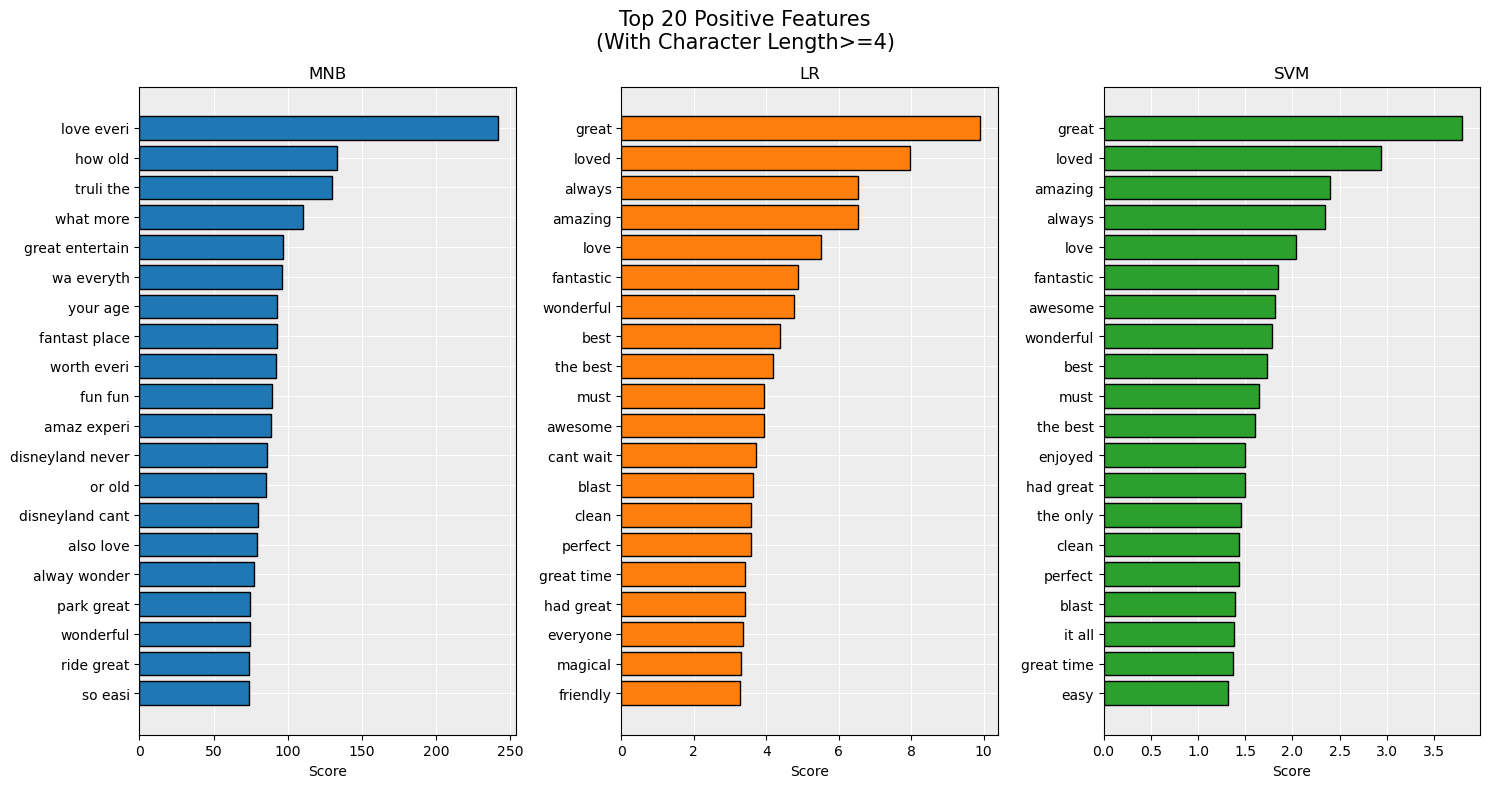

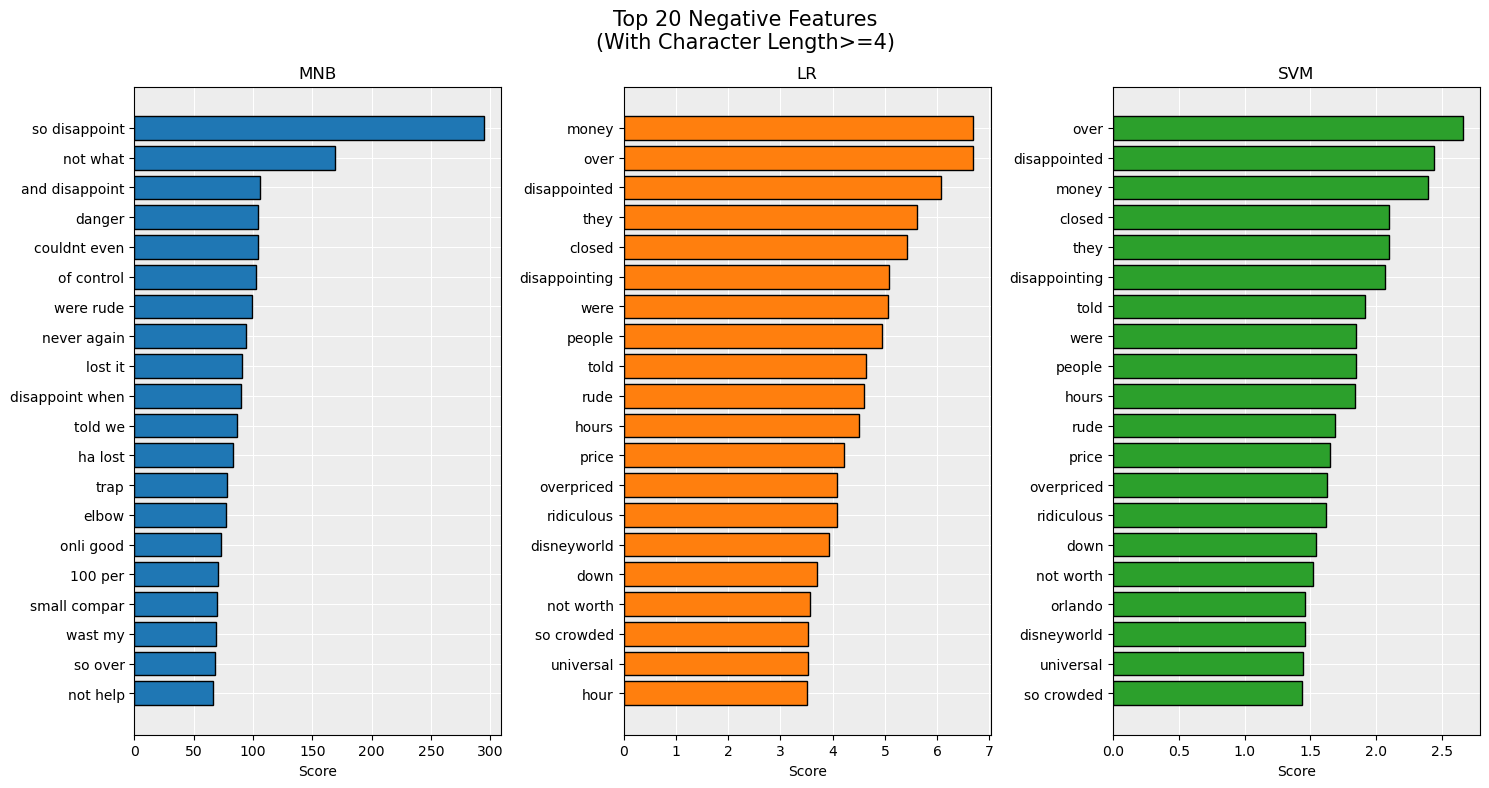

In [35]:
#set top num of words, and their minimum character and n-gram lengths
top = 20
min_feature_len = 4
n_gram_len = None

#plot positive features
cls = 'positive'
fig, axes = plt.subplots(1,3, figsize = (15,8))
feature_analyzers = [MNB_feature_analyzer,LR_feature_analyzer,SVM_feature_analyzer]
colors = ['C0','C1','C2']
for analyzer,c,ax in zip(feature_analyzers,colors,axes):
    analyzer.plot_feature_scores(top = top, cls = cls, 
                                 min_feature_len = min_feature_len, 
                                 n_gram_len = n_gram_len,
                                 color = c, ax = ax)
fig.tight_layout()

#plot negative features
cls = 'negative'
fig, axes = plt.subplots(1,3, figsize = (15,8))
feature_analyzers = [MNB_feature_analyzer,LR_feature_analyzer,SVM_feature_analyzer]
colors = ['C0','C1','C2']
for analyzer,c,ax in zip(feature_analyzers,colors,axes):
    analyzer.plot_feature_scores(top = top, cls = cls, 
                                 min_feature_len = min_feature_len, 
                                 n_gram_len = n_gram_len,
                                 color = c, ax = ax)
fig.tight_layout()

To dig a bit deeper, particularly for the LR and SVM models, which had many uni-gram top features, we will next look only at bi-gram features. Here we see some additional phrases that suggest why customers are leaving positive and negative reviews. On the positive side, we have terms like "all ages" and "for everyone," while on the negative side we have terms like "broke down," "long lines," "hour wait," and "many people." We also see the name of a competitor &mdash; "universal studios" &mdash; listed among the most negative features.

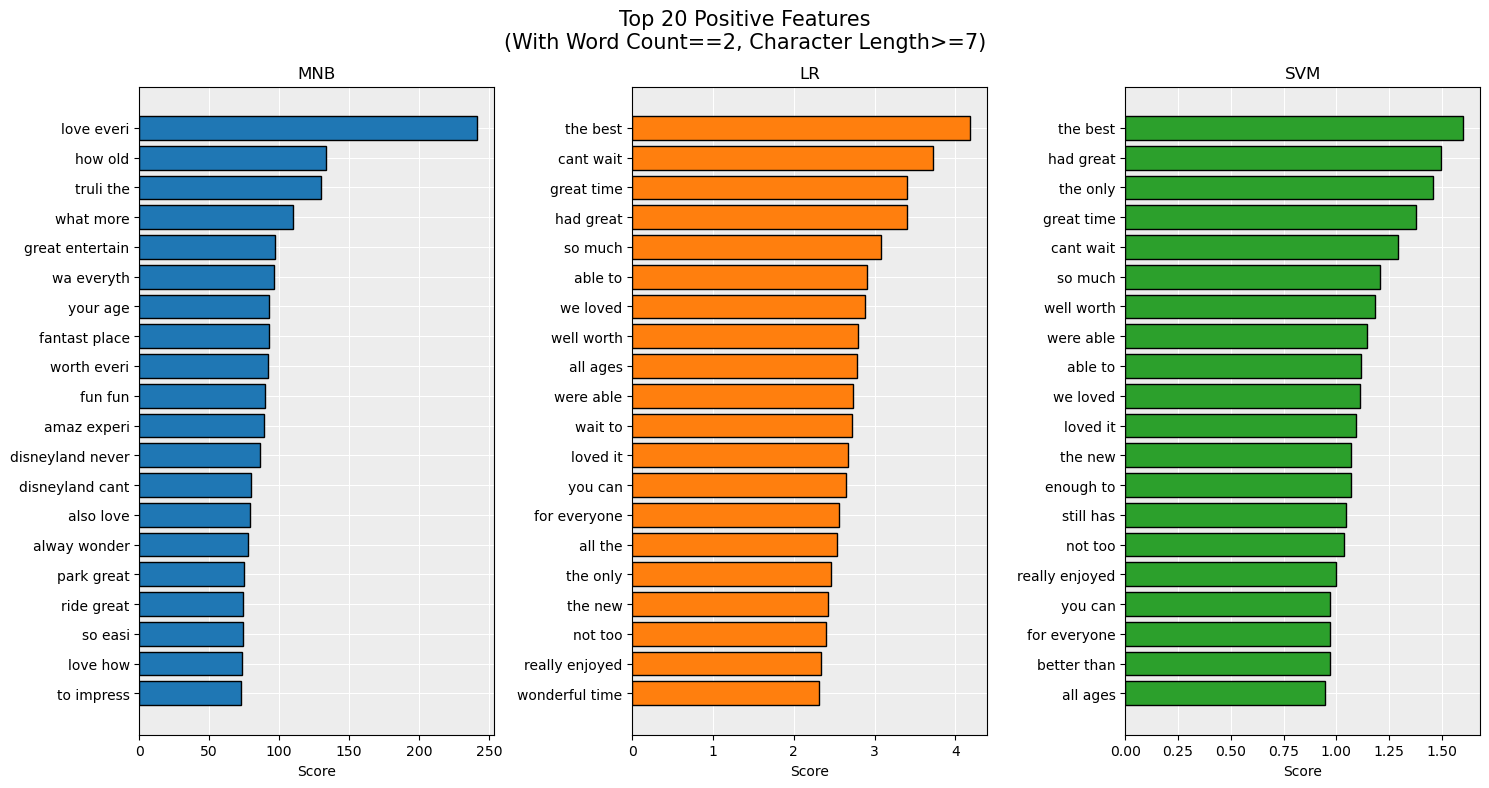

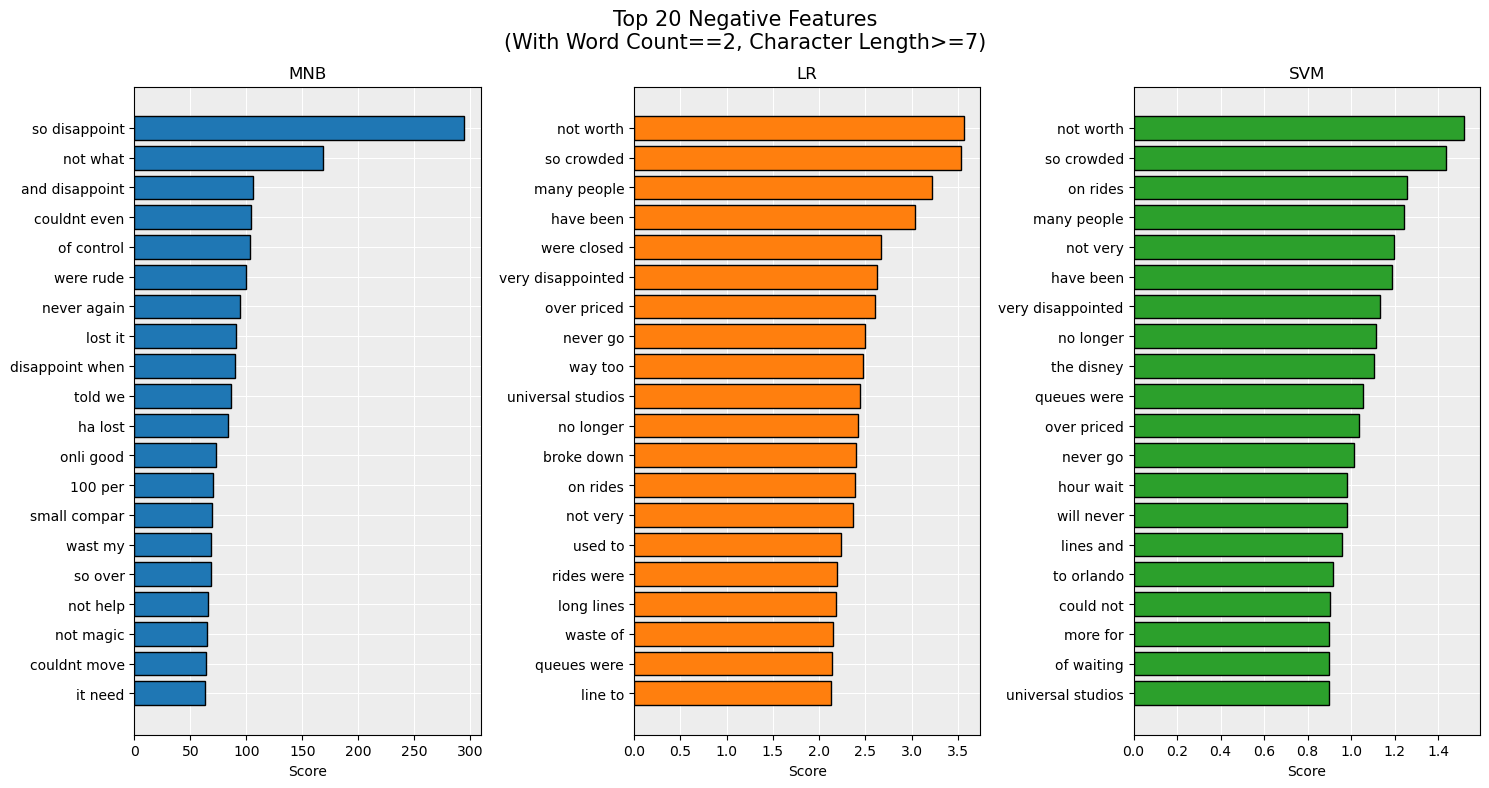

In [36]:
#set top num of words, and their minimum character and n-gram lengths
top = 20
min_feature_len = 7
n_gram_len = 2

#plot positive features
cls = 'positive'
fig, axes = plt.subplots(1,3, figsize = (15,8))
feature_analyzers = [MNB_feature_analyzer,LR_feature_analyzer,SVM_feature_analyzer]
colors = ['C0','C1','C2']
for analyzer,c,ax in zip(feature_analyzers,colors,axes):
    analyzer.plot_feature_scores(top = top, cls = cls, 
                                 min_feature_len = min_feature_len, 
                                 n_gram_len = n_gram_len,
                                 color = c, ax = ax)
fig.tight_layout()

#plot negative features
cls = 'negative'
fig, axes = plt.subplots(1,3, figsize = (15,8))
feature_analyzers = [MNB_feature_analyzer,LR_feature_analyzer,SVM_feature_analyzer]
colors = ['C0','C1','C2']
for analyzer,c,ax in zip(feature_analyzers,colors,axes):
    analyzer.plot_feature_scores(top = top, cls = cls, 
                                 min_feature_len = min_feature_len, 
                                 n_gram_len = n_gram_len,
                                 color = c, ax = ax)
fig.tight_layout()

## Summary and Conclusion

This notebook has examined the ability of three different machine learning algorithms to classify customer reviews of Disneyland's amusement park in California as either positive or negative based on the text of the reviews. The models performed reasonably well, with mean cross-validation and testing accuracy scores in the 0.85-0.86 range. None of the three frameworks proved significantly better than the others in terms of cross-validation accuracy, and model performance on the hold-out testing set was not dramatically different with respect to accuracy or other metrics, including sensitivity, specificity, and AUC scores. An analysis of different feature scores that the models generated helped illuminate words that tended to be associated with positive and negative sentiment. Some of these words were even able to offer specific insights into particular areas of praise &mdash; e.g., "clean" and "friendly" &mdash; and criticism &mdash; e.g., "overpriced," "rude," and "long lines."

For further research, it would be interesting to explore whether additional feature engineering could help improve model performance. For instance, including features related to overall text length, capitalization, or punctuation could impact accuracy. This may require experimentation with feature scaling as well &mdash; e.g., features such as text length would have much larger values than any of the n-gram features, and could therefore skew algorithms such as SVM that are sensitive to scale. In addition, it may be interesting to try to group different high-scoring features into broader themes. Several of the top-scoring features highlighted above seemed to touch on related topics. For example, it might make sense to group "overpriced," "price," "money" and other similar words into a common pricing theme. This could be done informally by subject matter experts, or more systematically by using a quantitative scoring criteria based on established tools, such as the WordNet database,<a name="cite_ref-17"></a>[<sup>[17]</sup>](#cite_note-17) for which NLTK provides an interface.<a name="cite_ref-18"></a>[<sup>[18]</sup>](#cite_note-18) Lastly, it would be useful to compare how the performance of more advanced deep learning frameworks, such as Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), stack up against the algorithms explored here. 

<a name="cite_note-17"></a><font size = "1.5">17. [^](#cite_ref-17) </font></a><font size = "1.5">Princeton University. (2010). "About WordNet." https://wordnet.princeton.edu/ (Last accessed 11/26/2023)</font><br>
<a name="cite_note-18"></a><font size = "1.5">18. [^](#cite_ref-18) </font></a><font size = "1.5">NLTK. (2023). "Sample usage for wordnet." https://www.nltk.org/howto/wordnet.html (Last accessed 11/26/2023).</font><br>